BUSINESS UNDERSTANDING
The Superstore Sales dataset provides comprehensive sales data for multiple products sold by a retail superstore. This dataset is suitable for exploring various aspects of sales analysis, including trend analysis, product performance, geographical segmentation, and consumer behavior. This dataset can be accessed at the link https://www.kaggle.com/datasets/aditisaxena20/superstore-sales-dataset/code

BUSINESS QUESTION
Who are our most profitable customers?
What are the distinct characteristics of each customer segment?
Which products or services are preferred by different segments?

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
from dateutil import parser
%matplotlib inline

In [2]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
df = pd.read_csv('SuperStoreOrders.csv')

In [4]:
df.head()

order_id order_date ship_date       ship_mode    customer_name  \
0     AG-2011-2040   1/1/2011  6/1/2011  Standard Class  Toby Braunhardt   
1    IN-2011-47883   1/1/2011  8/1/2011  Standard Class      Joseph Holt   
2     HU-2011-1220   1/1/2011  5/1/2011    Second Class    Annie Thurman   
3  IT-2011-3647632   1/1/2011  5/1/2011    Second Class     Eugene Moren   
4    IN-2011-47883   1/1/2011  8/1/2011  Standard Class      Joseph Holt   

       segment            state    country  market   region  ...  \
0     Consumer      Constantine    Algeria  Africa   Africa  ...   
1     Consumer  New South Wales  Australia    APAC  Oceania  ...   
2     Consumer         Budapest    Hungary    EMEA     EMEA  ...   
3  Home Office        Stockholm     Sweden      EU    North  ...   
4     Consumer  New South Wales  Australia    APAC  Oceania  ...   

          category sub_category                 product_name sales quantity  \
0  Office Supplies      Storage          Tenex Lockers, Blue   408        2   
1  Office Supplies     Supplies     Acme Trimmer, High Speed   120        3   
2  Office Supplies      Storage      Tenex Box, Single Width    66        4   
3  Office Supplies        Paper  Enermax Note Cards, Premium    45        3   
4        Furniture  Furnishings   Eldon Light Bulb, Duo Pack   114        5   

   discount   profit  shipping_cost  order_priority  year  
0       0.0  106.140          35.46          Medium  2011  
1       0.1   36.036           9.72          Medium  2011  
2       0.0   29.640           8.17            High  2011  
3       0.5  -26.055           4.82            High  2011  
4       0.1   37.770           4.70          Medium  2011  

[5 rows x 21 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        51290 non-null  object 
 1   order_date      51290 non-null  object 
 2   ship_date       51290 non-null  object 
 3   ship_mode       51290 non-null  object 
 4   customer_name   51290 non-null  object 
 5   segment         51290 non-null  object 
 6   state           51290 non-null  object 
 7   country         51290 non-null  object 
 8   market          51290 non-null  object 
 9   region          51290 non-null  object 
 10  product_id      51290 non-null  object 
 11  category        51290 non-null  object 
 12  sub_category    51290 non-null  object 
 13  product_name    51290 non-null  object 
 14  sales           51290 non-null  object 
 15  quantity        51290 non-null  int64  
 16  discount        51290 non-null  float64
 17  profit          51290 non-null 

order_id: A unique identifier for each order.
order_date: The date when the order was placed.
ship_date: The date when the order was shipped.
ship_mode: The method used for shipping the order.
customer_name: The name of the customer who placed the order.
segment: The market segment to which the customer belongs.
state: The state where the order was placed.
country: The country where the order was placed.
market: The market in which the order was placed.
region: The region in which the order was placed.
product_id: A unique identifier for each product.
category: The broad category to which the product belongs.
sub_category: A more specific category within the broader category.
product_name: The name of the product.
sales: The total sales amount for the order.
quantity: The quantity of products ordered.
discount: The discount applied to the order.
profit: The profit generated from the order.
shipping_cost: The cost associated with shipping the order.
order_priority: The priority level of the order.
year: The year in which the order was placed.

In [6]:
df.describe().T

count         mean         std       min      25%      50%  \
quantity       51290.0     3.476545    2.278766     1.000     2.00     3.00   
discount       51290.0     0.142908    0.212280     0.000     0.00     0.00   
profit         51290.0    28.641740  174.424113 -6599.978     0.00     9.24   
shipping_cost  51290.0    26.375915   57.296804     0.000     2.61     7.79   
year           51290.0  2012.777208    1.098931  2011.000  2012.00  2013.00   

                   75%       max  
quantity          5.00    14.000  
discount          0.20     0.850  
profit           36.81  8399.976  
shipping_cost    24.45   933.570  
year           2014.00  2014.000

In [7]:
df.describe(include='object').T

count unique              top   freq
order_id        51290  25035   CA-2014-100111     14
order_date      51290   1430       18-06-2014    135
ship_date       51290   1464       22-11-2014    130
ship_mode       51290      4   Standard Class  30775
customer_name   51290    795  Muhammed Yedwab    108
segment         51290      3         Consumer  26518
state           51290   1094       California   2001
country         51290    147    United States   9994
market          51290      7             APAC  11002
region          51290     13          Central  11117
product_id      51290  10292  OFF-AR-10003651     35
category        51290      3  Office Supplies  31273
sub_category    51290     17          Binders   6152
product_name    51290   3788          Staples    227
sales           51290   2246               13    589
order_priority  51290      4           Medium  29433

Inferences of Summary Statistics
Quantity: The average quantity per order is around 3.48 items, with a standard deviation of approximately 2.28. The quantity ranges from 1 to 14 items.
Discount: On average, there is a discount of about 14.29% per order, with a standard deviation of approximately 21.23%. The discount varies from 0% to 85%.
Profit: The mean profit per order is roughly $28.64, with a considerable standard deviation of approximately $174.42. Profit ranges from  - $6599.98 to a gain of $8399.98.
Shipping Cost: The average shipping cost per order is around $26.38, with a standard deviation of approximately $57.30. Shipping costs range from $0.00 to $933.57.
Inferences of Summary Statistics
order_id: There are 25,035 unique order IDs, with "CA-2014-100111" being the most frequent, occurring 14 times.
ship_mode: There are 4 unique shipping modes, with "Standard Class" being the most frequent, occurring 30,775 times.
customer_name: There are 795 unique customer names, with "Muhammed Yedwab" being the most frequent, occurring 108 times.
segment: There are 3 unique market segments, with "Consumer" being the most frequent, occurring 26,518 times.
country: There are 147 unique countries, with "United States" being the most frequent, occurring 9,994 times.
market: There are 7 unique markets, with "APAC" (Asia-Pacific) being the most frequent, occurring 11,002 times.
region: There are 13 unique regions, with "Central" being the most frequent, occurring 11,117 times.
product_id: There are 10,292 unique product IDs, with "OFF-AR-10003651" being the most frequent, occurring 35 times.
category: There are 3 unique categories, with "Office Supplies" being the most frequent, occurring 31,273 times.
sub_category: There are 17 unique sub-categories, with "Binders" being the most frequent, occurring 6,152 times.
product_name: There are 3,788 unique product names, with "Staples" being the most frequent, occurring 227 times.
order_priority: There are 4 unique order priorities, with "Medium" being the most frequent, occurring 29,433 times.

In [8]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['order_id'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

Empty DataFrame
Columns: [order_id, order_date, ship_date, ship_mode, customer_name, segment, state, country, market, region, product_id, category, sub_category, product_name, sales, quantity, discount, profit, shipping_cost, order_priority, year]
Index: []

[0 rows x 21 columns]

In [9]:
df['profit'].describe()

count    51290.000000
mean        28.641740
std        174.424113
min      -6599.978000
25%          0.000000
50%          9.240000
75%         36.810000
max       8399.976000
Name: profit, dtype: float64

In [10]:
df[df['profit']<0].describe()[['quantity']]

quantity
count  12543.000000
mean       3.427011
std        2.277561
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       14.000000

In [11]:
df = df[df['profit'] > 0]

In [12]:
df

order_id  order_date ship_date       ship_mode     customer_name  \
0        AG-2011-2040    1/1/2011  6/1/2011  Standard Class   Toby Braunhardt   
1       IN-2011-47883    1/1/2011  8/1/2011  Standard Class       Joseph Holt   
2        HU-2011-1220    1/1/2011  5/1/2011    Second Class     Annie Thurman   
4       IN-2011-47883    1/1/2011  8/1/2011  Standard Class       Joseph Holt   
5       IN-2011-47883    1/1/2011  8/1/2011  Standard Class       Joseph Holt   
...               ...         ...       ...             ...               ...   
51284  MX-2014-108574  31-12-2014  4/1/2015  Standard Class     Julia Barnett   
51285  CA-2014-115427  31-12-2014  4/1/2015  Standard Class        Erica Bern   
51286    MO-2014-2560  31-12-2014  5/1/2015  Standard Class         Liz Preis   
51287  MX-2014-110527  31-12-2014  2/1/2015    Second Class  Charlotte Melton   
51288  MX-2014-114783  31-12-2014  6/1/2015  Standard Class     Tamara Dahlen   

           segment             state        country  market   region  ...  \
0         Consumer       Constantine        Algeria  Africa   Africa  ...   
1         Consumer   New South Wales      Australia    APAC  Oceania  ...   
2         Consumer          Budapest        Hungary    EMEA     EMEA  ...   
4         Consumer   New South Wales      Australia    APAC  Oceania  ...   
5         Consumer   New South Wales      Australia    APAC  Oceania  ...   
...            ...               ...            ...     ...      ...  ...   
51284  Home Office        Tamaulipas         Mexico   LATAM    North  ...   
51285    Corporate        California  United States      US     West  ...   
51286     Consumer  Souss-Massa-Draâ        Morocco  Africa   Africa  ...   
51287     Consumer           Managua      Nicaragua   LATAM  Central  ...   
51288     Consumer         Chihuahua         Mexico   LATAM    North  ...   

              category sub_category  \
0      Office Supplies      Storage   
1      Office Supplies     Supplies   
2      Office Supplies      Storage   
4            Furniture  Furnishings   
5      Office Supplies        Paper   
...                ...          ...   
51284  Office Supplies       Labels   
51285  Office Supplies      Binders   
51286  Office Supplies      Binders   
51287  Office Supplies       Labels   
51288  Office Supplies       Labels   

                                          product_name sales quantity  \
0                                  Tenex Lockers, Blue   408        2   
1                             Acme Trimmer, High Speed   120        3   
2                              Tenex Box, Single Width    66        4   
4                           Eldon Light Bulb, Duo Pack   114        5   
5              Eaton Computer Printout Paper, 8.5 x 11    55        2   
...                                                ...   ...      ...   
51284         Novimex Legal Exhibit Labels, Adjustable    17        3   
51285  Cardinal Slant-D Ring Binder, Heavy Gauge Vinyl    14        2   
51286          Wilson Jones Hole Reinforcements, Clear     4        1   
51287           Hon Color Coded Labels, 5000 Label Set    26        3   
51288           Hon Legal Exhibit Labels, Alphabetical     7        1   

       discount    profit  shipping_cost  order_priority  year  
0           0.0  106.1400          35.46          Medium  2011  
1           0.1   36.0360           9.72          Medium  2011  
2           0.0   29.6400           8.17            High  2011  
4           0.1   37.7700           4.70          Medium  2011  
5           0.1   15.3420           1.80          Medium  2011  
...         ...       ...            ...             ...   ...  
51284       0.0    0.6600           1.32          Medium  2014  
51285       0.2    4.5188           0.89          Medium  2014  
51286       0.0    0.4200           0.49          Medium  2014  
51287       0.0   12.3600           0.35          Medium  2014  
51288       0.0    0.5600           0.20          Medi

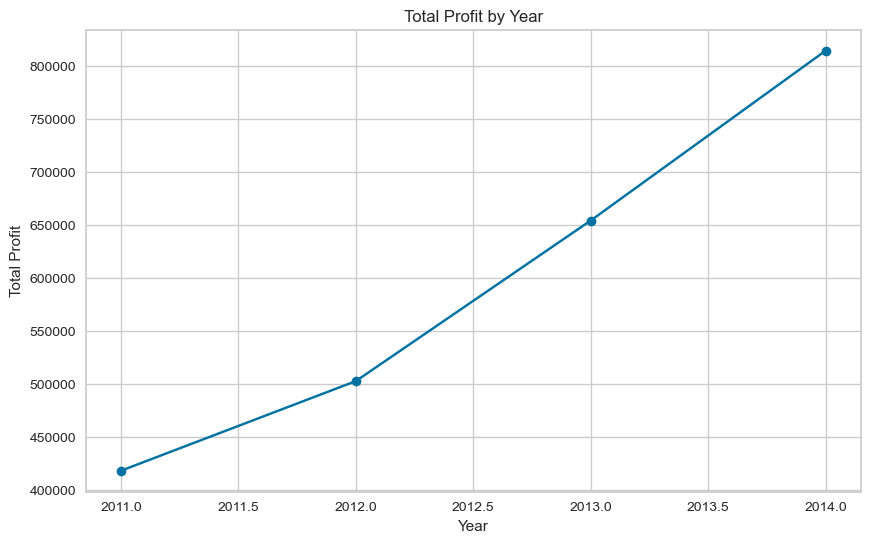

In [13]:
yearly_profit = df.groupby('year')['profit'].sum().reset_index()

# Step 2: Create a line chart using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(yearly_profit['year'], yearly_profit['profit'], marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title('Total Profit by Year')
plt.xlabel('Year')
plt.ylabel('Total Profit')

# Display the line chart
plt.grid(True)
plt.show()

It appears that the profit has consistently increased year by year, especially noticeable from 2012 to 2014, indicating significant growth in profitability over this period.

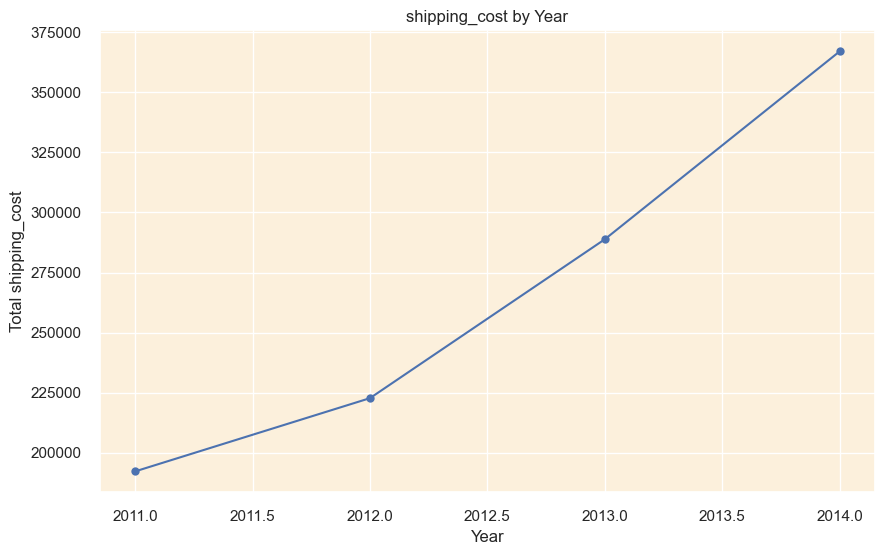

In [74]:
yearly_shipping_cost = df.groupby('year')['shipping_cost'].sum().reset_index()

# Step 2: Create a line chart using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(yearly_shipping_cost['year'], yearly_shipping_cost['shipping_cost'], marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title('shipping_cost by Year')
plt.xlabel('Year')
plt.ylabel('Total shipping_cost')

# Display the line chart
plt.grid(True)
plt.show()

The increase in shipping costs is attributed to the increase in the number of purchases during those years. Similar to profit, shipping costs began to increase significantly from 2012 to 2014.

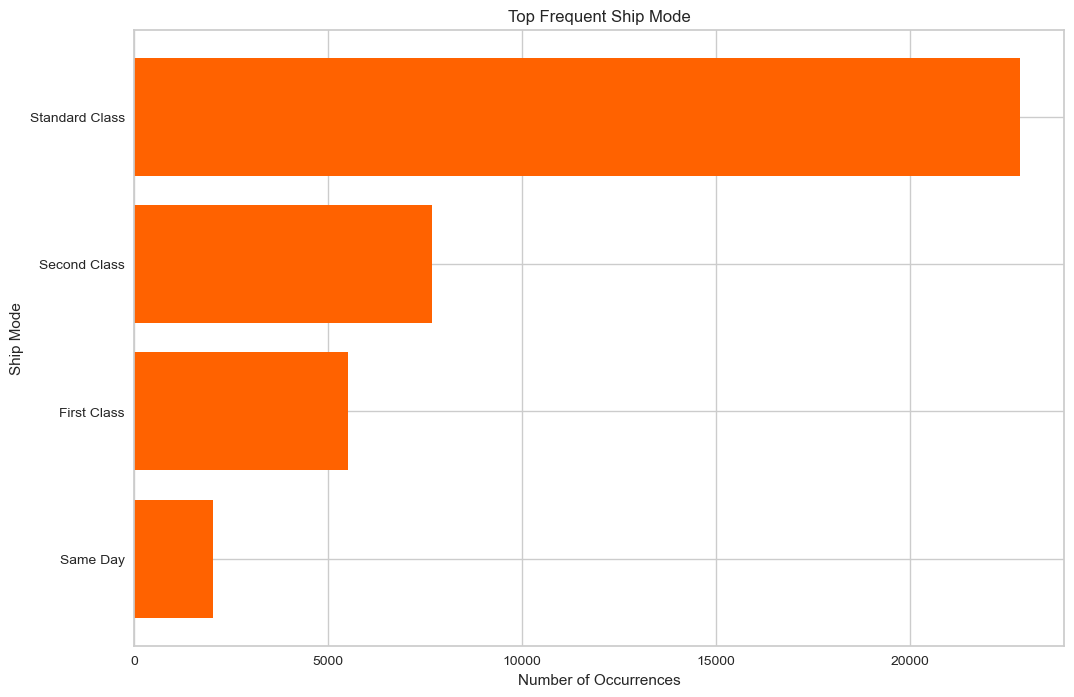

In [14]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['ship_mode'].value_counts()

# Get the top ship_mode
top_ship_mode = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_ship_mode.index[::-1], top_ship_mode.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Ship Mode')
plt.title('Top Frequent Ship Mode')

# Show the plot
plt.show()

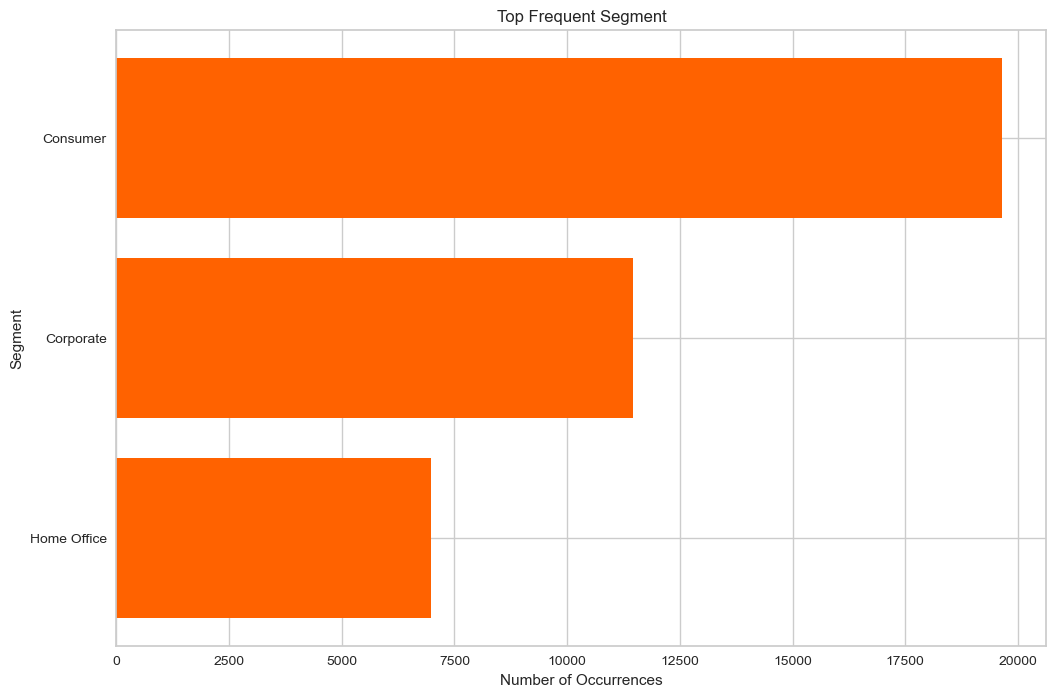

In [15]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['segment'].value_counts()

# Get the top Segment
top_Segment = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_Segment.index[::-1], top_Segment.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Segment')
plt.title('Top Frequent Segment')

# Show the plot
plt.show()

Standard class is the primary choice for customers as the most selected shipping mode because, in addition to being affordable, this shipping mode has a wide delivery range. The largest customer segment is consumers, indicating that many customers make transactions through the retail system. This also suggests that consumers are the most likely to make the most technology purchases.

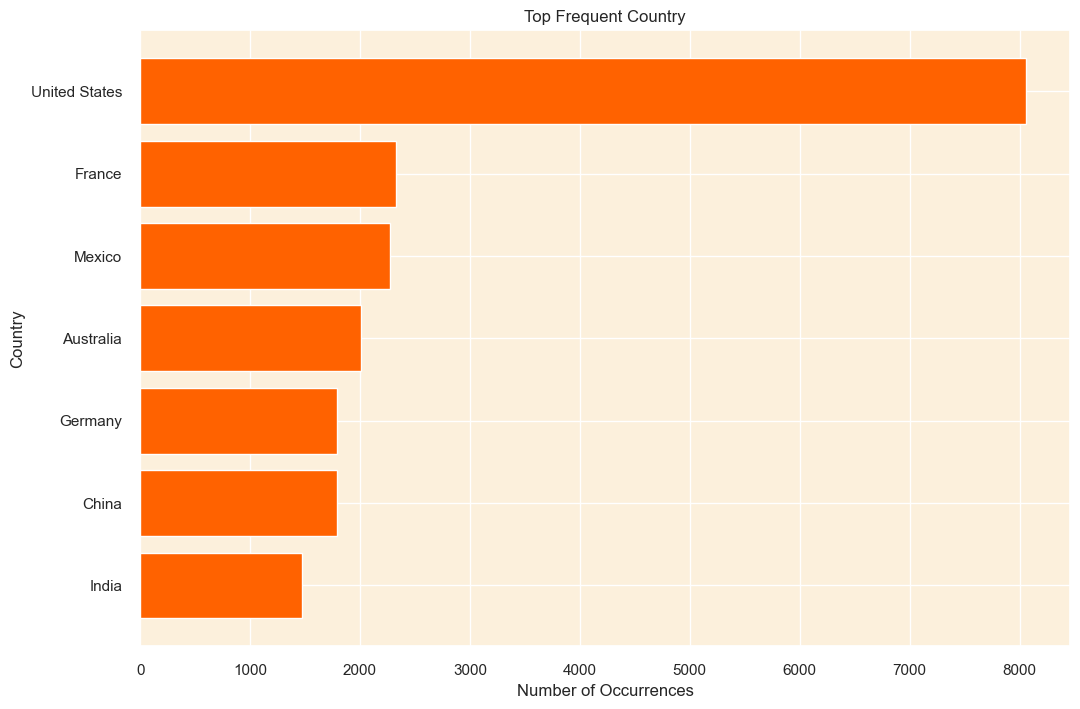

In [72]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['country'].value_counts()

# Get the top country
top_country = description_counts[:7]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_country.index[::-1], top_country.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Country')
plt.title('Top Frequent Country')

# Show the plot
plt.show()

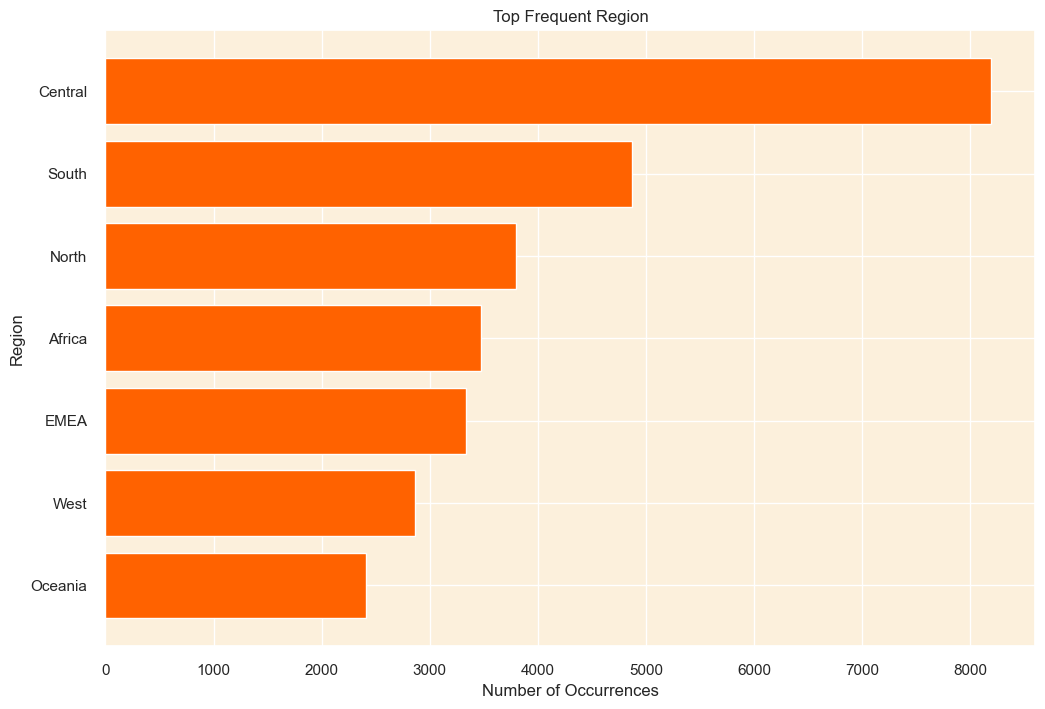

In [73]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['region'].value_counts()

# Get the top Region
top_Region = description_counts[:7]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_Region.index[::-1], top_Region.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Region')
plt.title('Top Frequent Region')

# Show the plot
plt.show()

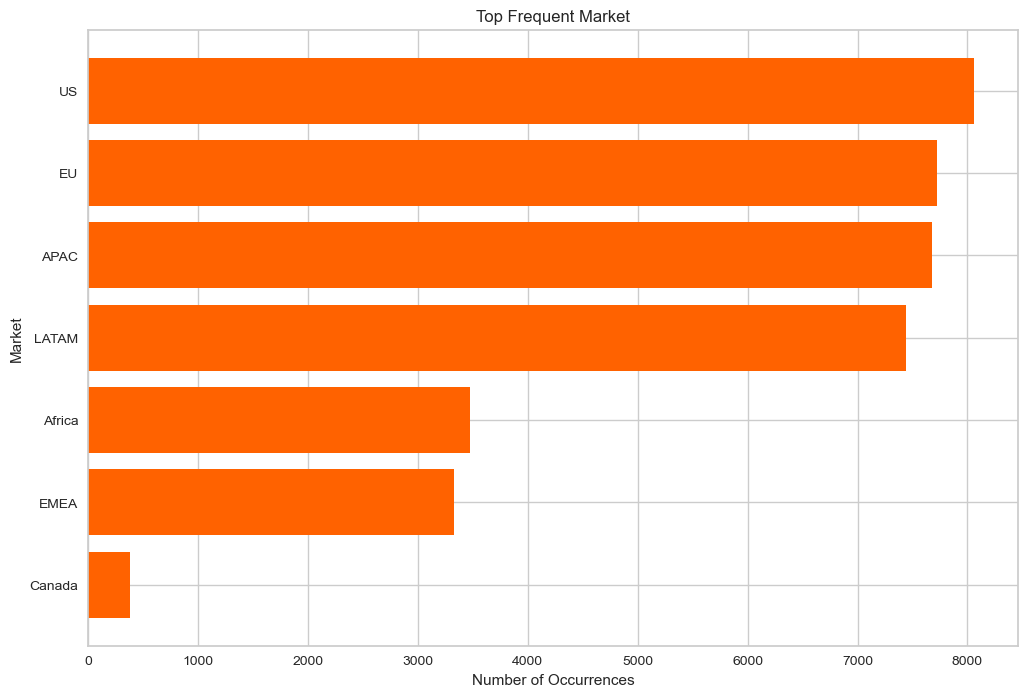

In [18]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['market'].value_counts()

# Get the top Market
top_Market = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_Market.index[::-1], top_Market.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Market')
plt.title('Top Frequent Market')

# Show the plot
plt.show()

The United States is the country with the highest frequency of shipments. Among the states, Central America has the highest frequency of shipments. However, from the total sales in the US, EU, APAC, and LATAM regions, the frequency is almost equally distributed.

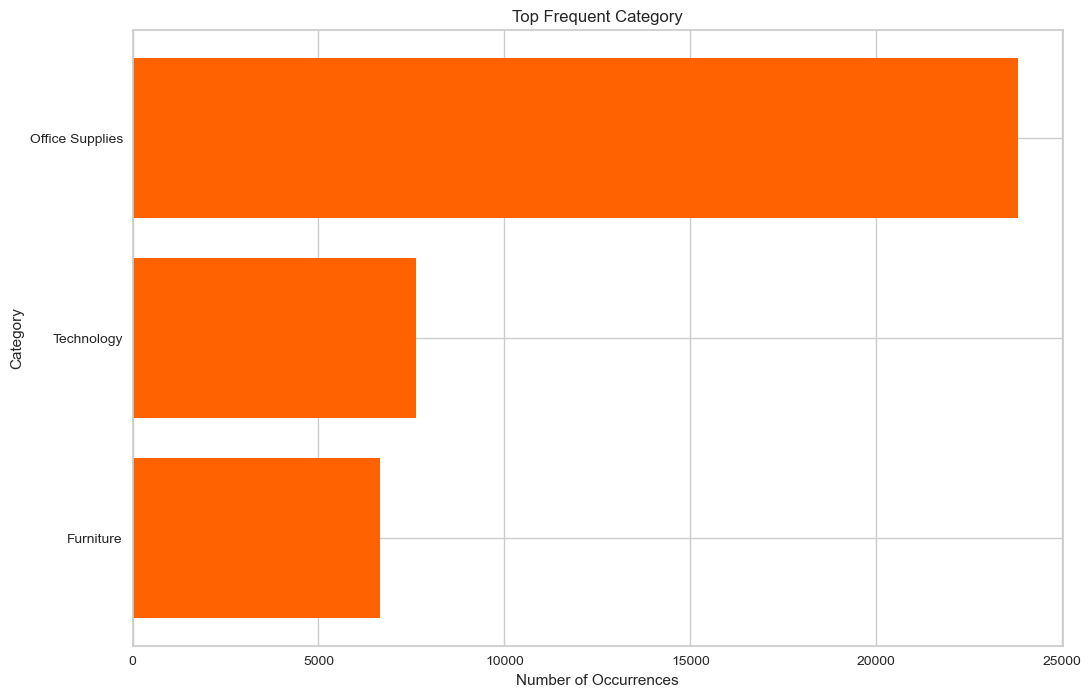

In [19]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['category'].value_counts()

# Get the top category
top_Category = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_Category.index[::-1], top_Category.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Category')
plt.title('Top Frequent Category')

# Show the plot
plt.show()

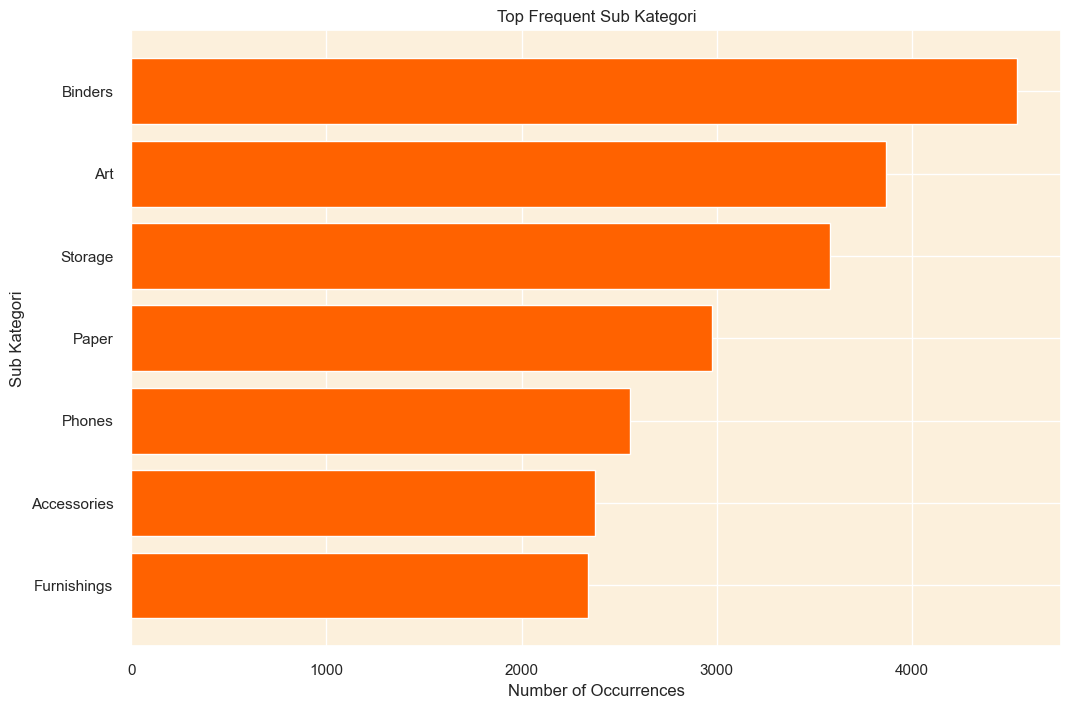

In [69]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['sub_category'].value_counts()

# Get the top 30 descriptions
top_sub_category = description_counts[:7]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_sub_category.index[::-1], top_sub_category.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Sub Kategori')
plt.title('Top Frequent Sub Kategori')

# Show the plot
plt.show()

The binder sub-category has become the top choice for customers to purchase in the store, with a significant difference compared to other sub-categories where purchases are much lower. The most frequently purchased product by customers is Staples. The purchase of Staples products is much higher compared to other products.

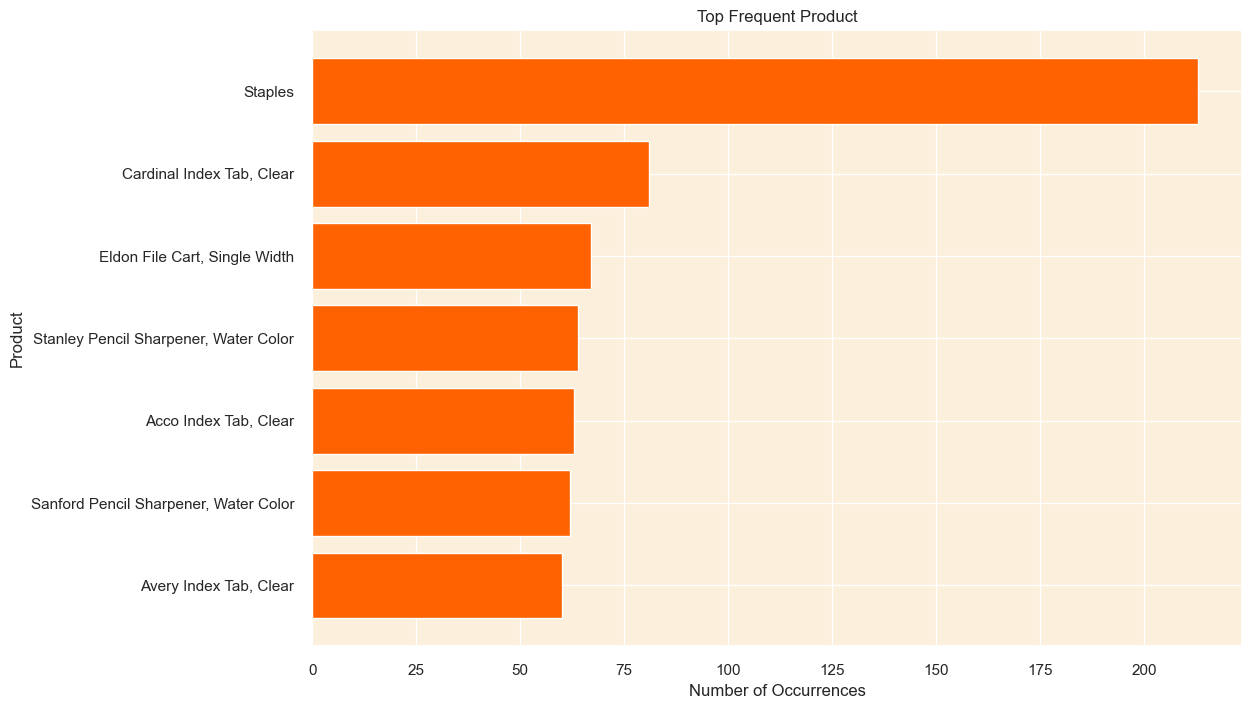

In [71]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['product_name'].value_counts()

# Get the topProduct
top_Product = description_counts[:7]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_Product.index[::-1], top_Product.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Product')
plt.title('Top Frequent Product')

# Show the plot
plt.show()

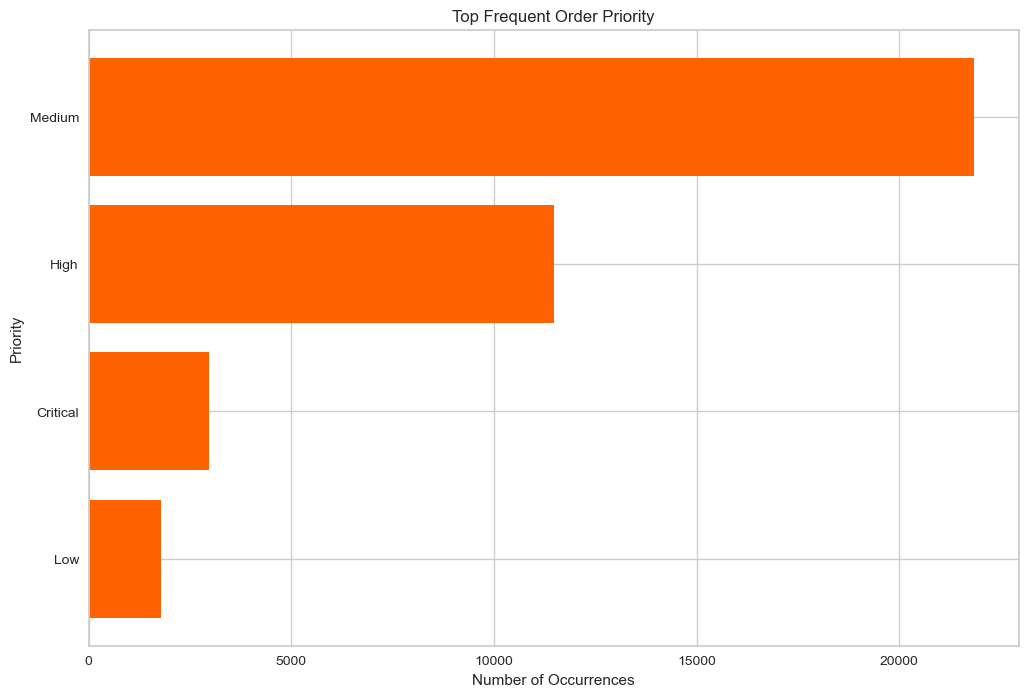

In [22]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['order_priority'].value_counts()

# Get the top _Priority
top_Priority = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_Priority.index[::-1], top_Priority.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Priority')
plt.title('Top Frequent Order Priority')

# Show the plot
plt.show()

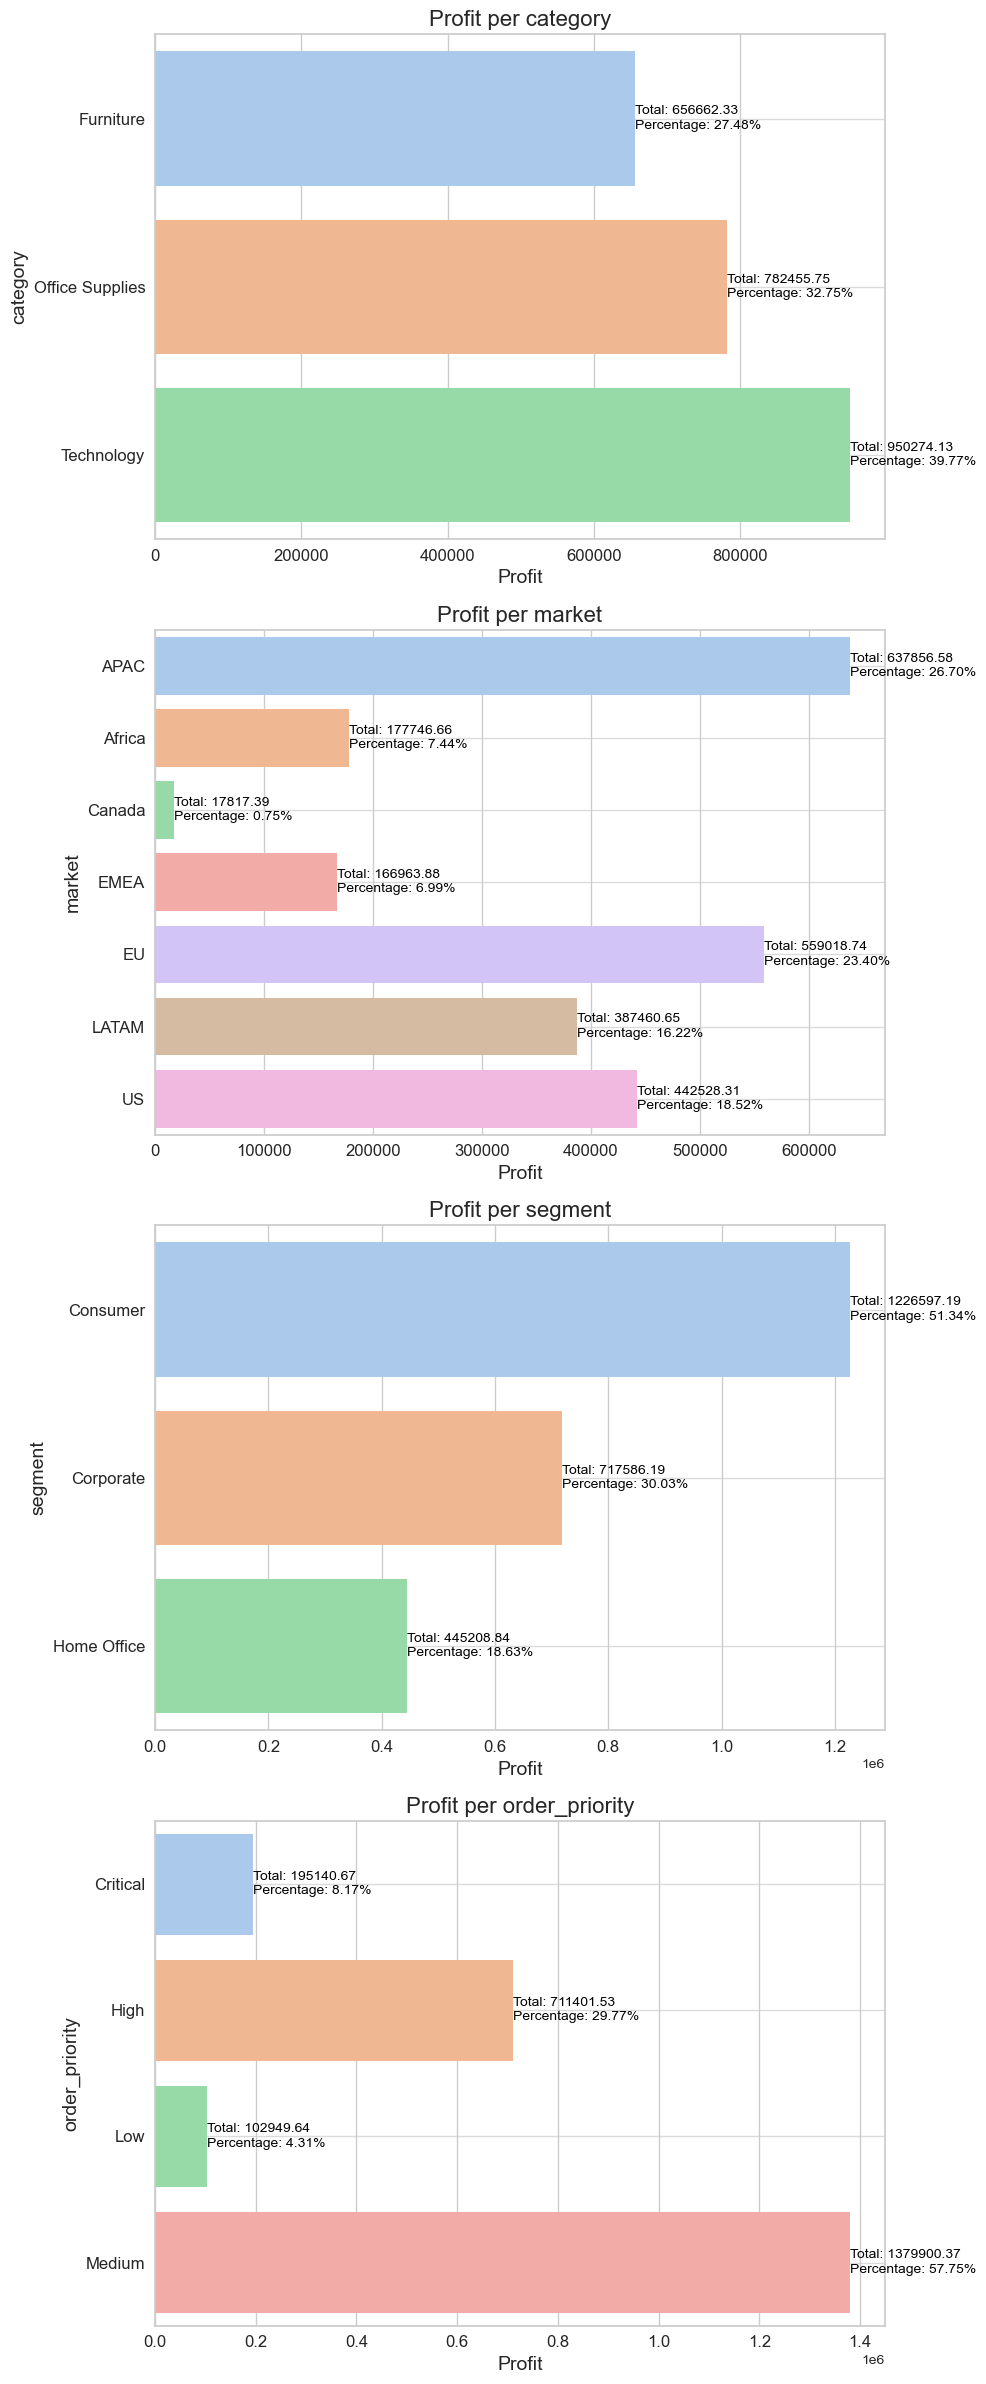

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# List semua kolom kategori
kategori_columns = ['category', 'market', 'segment','order_priority']

# Inisialisasi figure dan axes untuk subplot
fig, axes = plt.subplots(nrows=len(kategori_columns), ncols=1, figsize=(10, 6 * len(kategori_columns)))

# Menghitung total profit per kategori dan presentase profit
for idx, kategori_column in enumerate(kategori_columns):
    # Menghitung total profit per kategori
    total_profit = df.groupby(kategori_column)['profit'].sum().reset_index()
    
    # Menghitung presentase profit per kategori
    total_profit['percentage_profit'] = (total_profit['profit'] / total_profit['profit'].sum()) * 100
    
    # Membuat bar plot vertical menggunakan Seaborn
    sns.barplot(x='profit', y=kategori_column, data=total_profit, ax=axes[idx], palette='pastel')
    
    # Menambahkan nilai total profit dan presentase pada tiap bar
    for i, bar in enumerate(axes[idx].patches):
        axes[idx].text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                       f'Total: {total_profit.iloc[i]["profit"]:.2f}\nPercentage: {total_profit.iloc[i]["percentage_profit"]:.2f}%', 
                       va='center', ha='left', fontsize=10, color='black')
    
    # Menambahkan judul dan label pada setiap subplot
    axes[idx].set_title(f'Profit per {kategori_column}', fontsize=16)
    axes[idx].set_xlabel('Profit', fontsize=14)
    axes[idx].set_ylabel(f'{kategori_column}', fontsize=14)
    axes[idx].tick_params(axis='both', labelsize=12)
    axes[idx].grid(axis='y', alpha=0.7)

# Menampilkan plot
plt.tight_layout()
plt.show()


The technology category products generate more profit compared to office supplies, which was previously known to be the category with the highest sales volume. This indicates a significant difference in the cost price versus the selling price of the products.
The majority of profits based on market come from APAC, despite the previous knowledge that the US had the highest number of orders. This suggests that technology purchases in APAC far exceed those in the US. It's also noted that the profit per item generated from office supplies is not very high.
In terms of segment-based profit, the consumer segment, or purchases for personal rather than corporate or home office use, yields the highest profit. This further indicates that consumer purchases dominate in the technology category.
Regarding order priority, orders with a medium priority level generate the most profit, followed by high priority. This is because the quantity of medium priority orders is significantly higher than that of high and critical priority orders. This also suggests that the higher the priority of the order, the higher the profit per transaction.

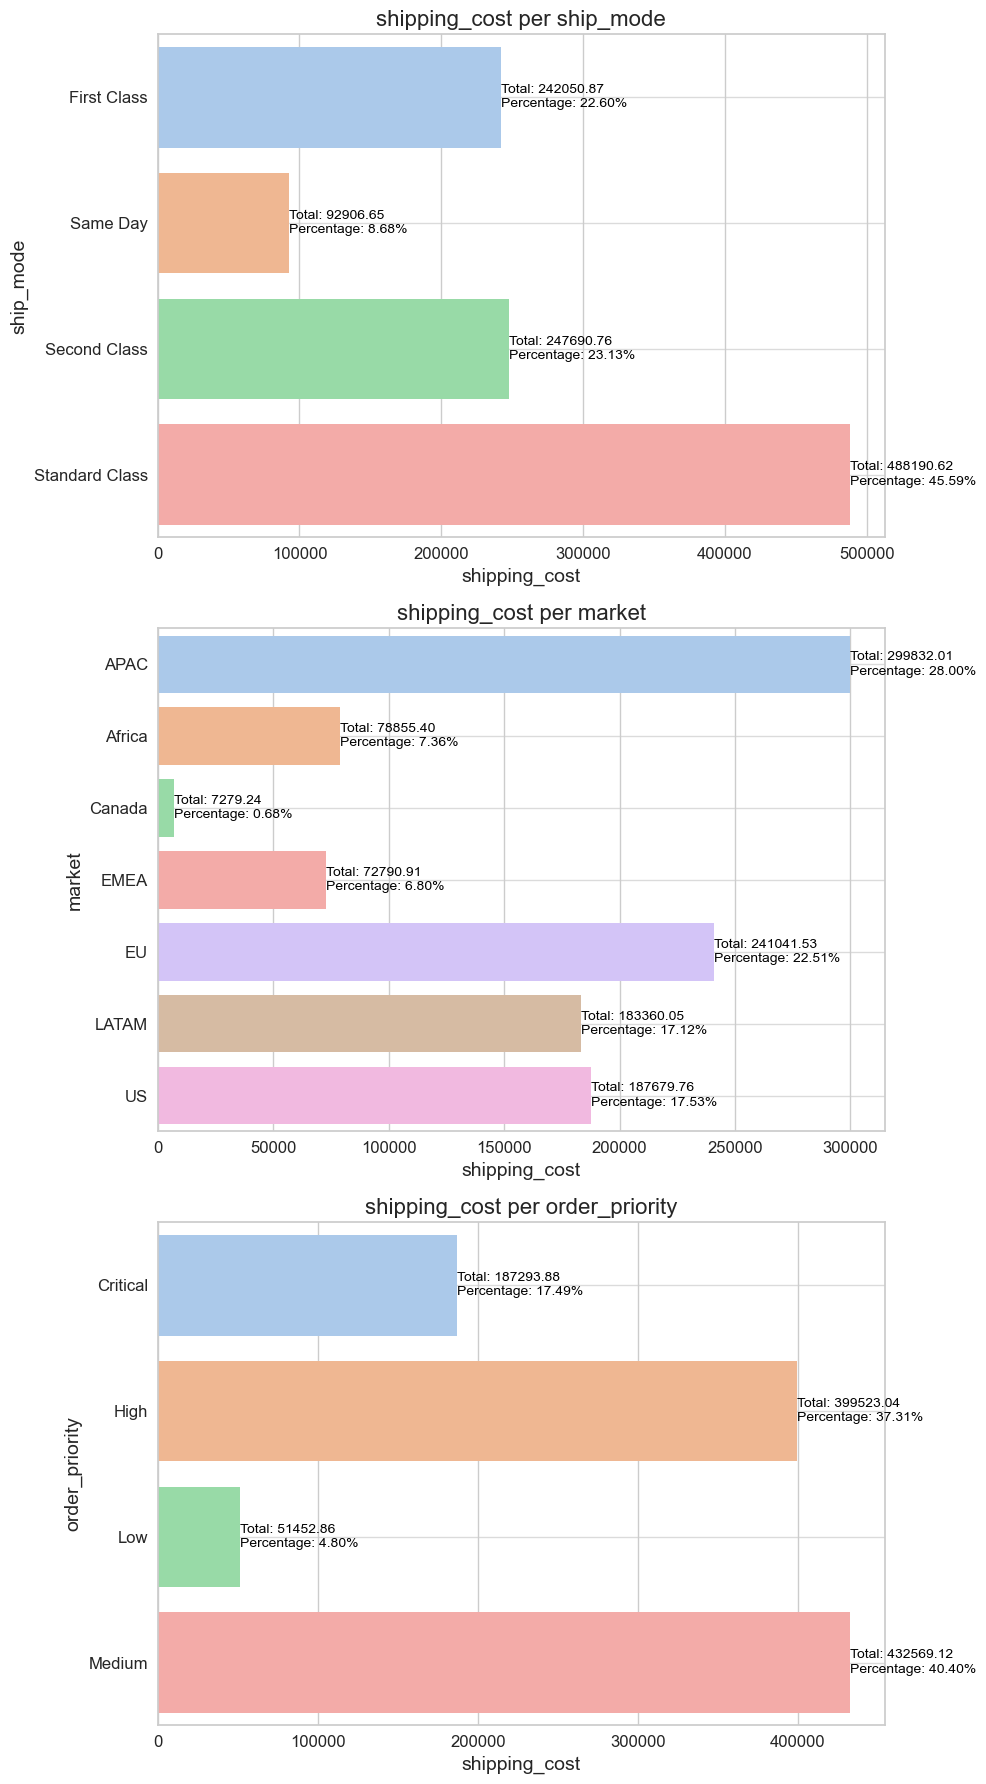

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# List semua kolom kategori
kategori_columns = ['ship_mode', 'market','order_priority']

# Inisialisasi figure dan axes untuk subplot
fig, axes = plt.subplots(nrows=len(kategori_columns), ncols=1, figsize=(10, 6 * len(kategori_columns)))

# Menghitung total profit per kategori dan presentase profit
for idx, kategori_column in enumerate(kategori_columns):
    # Menghitung total profit per kategori
    total_profit = df.groupby(kategori_column)['shipping_cost'].sum().reset_index()
    
    # Menghitung presentase profit per kategori
    total_profit['percentage_shipping_cost'] = (total_profit['shipping_cost'] / total_profit['shipping_cost'].sum()) * 100
    
    # Membuat bar plot vertical menggunakan Seaborn
    sns.barplot(x='shipping_cost', y=kategori_column, data=total_profit, ax=axes[idx], palette='pastel')
    
    # Menambahkan nilai total profit dan presentase pada tiap bar
    for i, bar in enumerate(axes[idx].patches):
        axes[idx].text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                       f'Total: {total_profit.iloc[i]["shipping_cost"]:.2f}\nPercentage: {total_profit.iloc[i]["percentage_shipping_cost"]:.2f}%', 
                       va='center', ha='left', fontsize=10, color='black')
    
    # Menambahkan judul dan label pada setiap subplot
    axes[idx].set_title(f'shipping_cost per {kategori_column}', fontsize=16)
    axes[idx].set_xlabel('shipping_cost', fontsize=14)
    axes[idx].set_ylabel(f'{kategori_column}', fontsize=14)
    axes[idx].tick_params(axis='both', labelsize=12)
    axes[idx].grid(axis='y', alpha=0.7)

# Menampilkan plot
plt.tight_layout()
plt.show()


The shipping cost based on priority is predominantly attributed to medium priority orders. However, when examining the profit generated from these priorities, it's evident that they are highly profitable, as seen from the significant amount of profit relative to the shipping cost incurred. The pricing strategy for products with medium priority appears to be very effective. Further exploration is needed for high and critical priorities to optimize product pricing for better profitability.
The shipping cost to APAC appears to be notably high, despite APAC not being the highest in terms of transaction volume. This indicates that shipping goods from the center to APAC is quite distant.
The shipping cost for the standard class is the highest among the shipping modes.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38079 entries, 0 to 51288
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        38079 non-null  object 
 1   order_date      38079 non-null  object 
 2   ship_date       38079 non-null  object 
 3   ship_mode       38079 non-null  object 
 4   customer_name   38079 non-null  object 
 5   segment         38079 non-null  object 
 6   state           38079 non-null  object 
 7   country         38079 non-null  object 
 8   market          38079 non-null  object 
 9   region          38079 non-null  object 
 10  product_id      38079 non-null  object 
 11  category        38079 non-null  object 
 12  sub_category    38079 non-null  object 
 13  product_name    38079 non-null  object 
 14  sales           38079 non-null  object 
 15  quantity        38079 non-null  int64  
 16  discount        38079 non-null  float64
 17  profit          38079 non-null  floa

In [26]:
df

order_id  order_date ship_date       ship_mode     customer_name  \
0        AG-2011-2040    1/1/2011  6/1/2011  Standard Class   Toby Braunhardt   
1       IN-2011-47883    1/1/2011  8/1/2011  Standard Class       Joseph Holt   
2        HU-2011-1220    1/1/2011  5/1/2011    Second Class     Annie Thurman   
4       IN-2011-47883    1/1/2011  8/1/2011  Standard Class       Joseph Holt   
5       IN-2011-47883    1/1/2011  8/1/2011  Standard Class       Joseph Holt   
...               ...         ...       ...             ...               ...   
51284  MX-2014-108574  31-12-2014  4/1/2015  Standard Class     Julia Barnett   
51285  CA-2014-115427  31-12-2014  4/1/2015  Standard Class        Erica Bern   
51286    MO-2014-2560  31-12-2014  5/1/2015  Standard Class         Liz Preis   
51287  MX-2014-110527  31-12-2014  2/1/2015    Second Class  Charlotte Melton   
51288  MX-2014-114783  31-12-2014  6/1/2015  Standard Class     Tamara Dahlen   

           segment             state        country  market   region  ...  \
0         Consumer       Constantine        Algeria  Africa   Africa  ...   
1         Consumer   New South Wales      Australia    APAC  Oceania  ...   
2         Consumer          Budapest        Hungary    EMEA     EMEA  ...   
4         Consumer   New South Wales      Australia    APAC  Oceania  ...   
5         Consumer   New South Wales      Australia    APAC  Oceania  ...   
...            ...               ...            ...     ...      ...  ...   
51284  Home Office        Tamaulipas         Mexico   LATAM    North  ...   
51285    Corporate        California  United States      US     West  ...   
51286     Consumer  Souss-Massa-Draâ        Morocco  Africa   Africa  ...   
51287     Consumer           Managua      Nicaragua   LATAM  Central  ...   
51288     Consumer         Chihuahua         Mexico   LATAM    North  ...   

              category sub_category  \
0      Office Supplies      Storage   
1      Office Supplies     Supplies   
2      Office Supplies      Storage   
4            Furniture  Furnishings   
5      Office Supplies        Paper   
...                ...          ...   
51284  Office Supplies       Labels   
51285  Office Supplies      Binders   
51286  Office Supplies      Binders   
51287  Office Supplies       Labels   
51288  Office Supplies       Labels   

                                          product_name sales quantity  \
0                                  Tenex Lockers, Blue   408        2   
1                             Acme Trimmer, High Speed   120        3   
2                              Tenex Box, Single Width    66        4   
4                           Eldon Light Bulb, Duo Pack   114        5   
5              Eaton Computer Printout Paper, 8.5 x 11    55        2   
...                                                ...   ...      ...   
51284         Novimex Legal Exhibit Labels, Adjustable    17        3   
51285  Cardinal Slant-D Ring Binder, Heavy Gauge Vinyl    14        2   
51286          Wilson Jones Hole Reinforcements, Clear     4        1   
51287           Hon Color Coded Labels, 5000 Label Set    26        3   
51288           Hon Legal Exhibit Labels, Alphabetical     7        1   

       discount    profit  shipping_cost  order_priority  year  
0           0.0  106.1400          35.46          Medium  2011  
1           0.1   36.0360           9.72          Medium  2011  
2           0.0   29.6400           8.17            High  2011  
4           0.1   37.7700           4.70          Medium  2011  
5           0.1   15.3420           1.80          Medium  2011  
...         ...       ...            ...             ...   ...  
51284       0.0    0.6600           1.32          Medium  2014  
51285       0.2    4.5188           0.89          Medium  2014  
51286       0.0    0.4200           0.49          Medium  2014  
51287       0.0   12.3600           0.35          Medium  2014  
51288       0.0    0.5600           0.20          Medi

# Feature Engineering
RFM stands for Recency, Frequency, and Monetary Value, and it is a method used in marketing analysis to segment customers based on their transaction history:
Recency (R): Refers to how recently a customer has made a purchase. It is usually measured in terms of the number of days since the last purchase. Customers who have made a purchase more recently are considered to be more valuable.
- Days_Since_Last_Purchase
Frequency (F): Indicates how often a customer makes a purchase within a specific period, such as a month or a year. Customers who make purchases more frequently are generally considered more valuable.
- Total_Transactions
- Total_Products_Purchased
- Unique_Products_Purchased
Monetary Value (M): Represents the total amount of money a customer has spent on purchases. This metric helps identify high-value customers who contribute significantly to revenue.
- Total_Profit
- Average_Transaction_Profit
Behavior features capture the actions and interactions of customers with a business. These features provide insights into the purchasing patterns, preferences, and engagement levels of customers.
- Day_Of_Week
- Is_SC
- Buy_OS
- Number_Using_Discount
- Discount_Rate
Geographic features refer to the location-based attributes associated with customer data. These features provide insights into where customers are located and how geographic factors influence their purchasing behavior.
- In_Americas
Profit trend features analyze the changes in profitability over time. These features help in understanding how profit margins and overall profitability evolve, often in relation to other variables like sales, costs, and market conditions.
- Monthly_Profit_Mean
- Monthly_Profit_Std
- Spending_Trend

In [27]:

# Convert all date strings to datetime objects using dateutil.parser
df['order_date'] = df['order_date'].apply(lambda x: parser.parse(x))
# Extract the date part
df['InvoiceDay'] = df['order_date'].dt.date
# Find the most recent purchase date for each customer
customer_data = df.groupby('order_id')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [28]:
customer_data

order_id  Days_Since_Last_Purchase
0      AG-2011-1070                      1187
1      AG-2011-1390                      1233
2      AG-2011-1440                      1112
3      AG-2011-2040                      1460
4      AG-2011-3090                      1236
...             ...                       ...
20130  ZA-2014-8160                       128
20131  ZA-2014-8330                        23
20132  ZA-2014-8690                       241
20133  ZA-2014-9260                       181
20134  ZA-2014-9750                       307

[20135 rows x 2 columns]

In [29]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('order_id')['order_date'].nunique().reset_index()
total_transactions.rename(columns={'order_date': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('order_id')['quantity'].sum().reset_index()
total_products_purchased.rename(columns={'quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='order_id')
customer_data = pd.merge(customer_data, total_products_purchased, on='order_id')

# Display the first few rows of the customer_data dataframe
customer_data.head()

order_id  Days_Since_Last_Purchase  Total_Transactions  \
0  AG-2011-1070                      1187                   1   
1  AG-2011-1390                      1233                   1   
2  AG-2011-1440                      1112                   1   
3  AG-2011-2040                      1460                   1   
4  AG-2011-3090                      1236                   1   

   Total_Products_Purchased  
0                         1  
1                        14  
2                         2  
3                         2  
4                         2

In [30]:
# Calculate the total spend by each customer
df['Total_Profit'] = df['profit'] * df['quantity']
total_profit = df.groupby('order_id')['Total_Profit'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_profit.merge(total_transactions, on='order_id')
average_transaction_value['Average_Transaction_Profit'] = average_transaction_value['Total_Profit'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_profit, on='order_id')
customer_data = pd.merge(customer_data, average_transaction_value[['order_id', 'Average_Transaction_Profit']], on='order_id')

# Display the first few rows of the customer_data dataframe
customer_data.head()

order_id  Days_Since_Last_Purchase  Total_Transactions  \
0  AG-2011-1070                      1187                   1   
1  AG-2011-1390                      1233                   1   
2  AG-2011-1440                      1112                   1   
3  AG-2011-2040                      1460                   1   
4  AG-2011-3090                      1236                   1   

   Total_Products_Purchased  Total_Profit  Average_Transaction_Profit  
0                         1         61.71                       61.71  
1                        14       2651.76                     2651.76  
2                         2         41.04                       41.04  
3                         2        212.28                      212.28  
4                         2         22.08                       22.08

In [31]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('order_id')['product_id'].nunique().reset_index()
unique_products_purchased.rename(columns={'product_id': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='order_id')

# Display the first few rows of the customer_data dataframe
customer_data.head()

order_id  Days_Since_Last_Purchase  Total_Transactions  \
0  AG-2011-1070                      1187                   1   
1  AG-2011-1390                      1233                   1   
2  AG-2011-1440                      1112                   1   
3  AG-2011-2040                      1460                   1   
4  AG-2011-3090                      1236                   1   

   Total_Products_Purchased  Total_Profit  Average_Transaction_Profit  \
0                         1         61.71                       61.71   
1                        14       2651.76                     2651.76   
2                         2         41.04                       41.04   
3                         2        212.28                      212.28   
4                         2         22.08                       22.08   

   Unique_Products_Purchased  
0                          1  
1                          2  
2                          1  
3                          1  
4                          1

In [32]:
df['Day_Of_Week'] = df['order_date'].dt.dayofweek
favorite_shopping_day = df.groupby(['order_id', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('order_id')['Count'].idxmax()][['order_id', 'Day_Of_Week']]
customer_data = pd.merge(customer_data, favorite_shopping_day, on='order_id')
customer_data.head()

order_id  Days_Since_Last_Purchase  Total_Transactions  \
0  AG-2011-1070                      1187                   1   
1  AG-2011-1390                      1233                   1   
2  AG-2011-1440                      1112                   1   
3  AG-2011-2040                      1460                   1   
4  AG-2011-3090                      1236                   1   

   Total_Products_Purchased  Total_Profit  Average_Transaction_Profit  \
0                         1         61.71                       61.71   
1                        14       2651.76                     2651.76   
2                         2         41.04                       41.04   
3                         2        212.28                      212.28   
4                         2         22.08                       22.08   

   Unique_Products_Purchased  Day_Of_Week  
0                          1            5  
1                          2            1  
2                          1            3  
3                          1            5  
4                          1            5

In [33]:
df['ship_mode'].value_counts(normalize=True).head()

ship_mode
Standard Class    0.600147
Second Class      0.201922
First Class       0.144857
Same Day          0.053074
Name: proportion, dtype: float64

In [34]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_ship_mode = df.groupby(['order_id', 'ship_mode']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_ship_mode= customer_ship_mode.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('order_id')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_ship_mode['Is_SC'] = customer_main_ship_mode['ship_mode'].apply(lambda x: 1 if x == 'Standard Class' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_ship_mode[['order_id', 'Is_SC']], on='order_id', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

order_id  Days_Since_Last_Purchase  Total_Transactions  \
0  AG-2011-1070                      1187                   1   
1  AG-2011-1390                      1233                   1   
2  AG-2011-1440                      1112                   1   
3  AG-2011-2040                      1460                   1   
4  AG-2011-3090                      1236                   1   

   Total_Products_Purchased  Total_Profit  Average_Transaction_Profit  \
0                         1         61.71                       61.71   
1                        14       2651.76                     2651.76   
2                         2         41.04                       41.04   
3                         2        212.28                      212.28   
4                         2         22.08                       22.08   

   Unique_Products_Purchased  Day_Of_Week  Is_SC  
0                          1            5      0  
1                          2            1      1  
2                          1            3      1  
3                          1            5      1  
4                          1            5      1

In [35]:
df['category'].value_counts(normalize=True).head()

category
Office Supplies    0.625489
Technology         0.199979
Furniture          0.174532
Name: proportion, dtype: float64

In [36]:

customer_category = df.groupby(['order_id', 'category']).size().reset_index(name='Number_of_Transactions')

customer_main_category= customer_category.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('order_id')

customer_main_category['Buy_OS'] = customer_main_category['category'].apply(lambda x: 1 if x == 'Office Supplies' else 0)

customer_data = pd.merge(customer_data, customer_main_category[['order_id', 'Buy_OS']], on='order_id', how='left')

customer_data.head()

order_id  Days_Since_Last_Purchase  Total_Transactions  \
0  AG-2011-1070                      1187                   1   
1  AG-2011-1390                      1233                   1   
2  AG-2011-1440                      1112                   1   
3  AG-2011-2040                      1460                   1   
4  AG-2011-3090                      1236                   1   

   Total_Products_Purchased  Total_Profit  Average_Transaction_Profit  \
0                         1         61.71                       61.71   
1                        14       2651.76                     2651.76   
2                         2         41.04                       41.04   
3                         2        212.28                      212.28   
4                         2         22.08                       22.08   

   Unique_Products_Purchased  Day_Of_Week  Is_SC  Buy_OS  
0                          1            5      0       1  
1                          2            1      1       1  
2                          1            3      1       1  
3                          1            5      1       1  
4                          1            5      1       0

In [37]:
df['market'].value_counts(normalize=True).head()

market
US        0.211613
EU        0.202841
APAC      0.201502
LATAM     0.195436
Africa    0.091205
Name: proportion, dtype: float64

In [38]:

customer_market = df.groupby(['order_id', 'market']).size().reset_index(name='Number_of_Transactions')

customer_main_market= customer_market.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('order_id')

customer_main_market['In_Americas'] = customer_main_market['market'].apply(lambda x: 1 if x == 'US' or x=='LATAM' else 0)

customer_data = pd.merge(customer_data, customer_main_market[['order_id', 'In_Americas']], on='order_id', how='left')

customer_data.head()

order_id  Days_Since_Last_Purchase  Total_Transactions  \
0  AG-2011-1070                      1187                   1   
1  AG-2011-1390                      1233                   1   
2  AG-2011-1440                      1112                   1   
3  AG-2011-2040                      1460                   1   
4  AG-2011-3090                      1236                   1   

   Total_Products_Purchased  Total_Profit  Average_Transaction_Profit  \
0                         1         61.71                       61.71   
1                        14       2651.76                     2651.76   
2                         2         41.04                       41.04   
3                         2        212.28                      212.28   
4                         2         22.08                       22.08   

   Unique_Products_Purchased  Day_Of_Week  Is_SC  Buy_OS  In_Americas  
0                          1            5      0       1            0  
1                          2            1      1       1            0  
2                          1            3      1       1            0  
3                          1            5      1       1            0  
4                          1            5      1       0            0

In [39]:
df['discount'].value_counts(normalize=True).head()

discount
0.00    0.746606
0.20    0.103338
0.10    0.084036
0.40    0.015783
0.17    0.013104
Name: proportion, dtype: float64

In [40]:
customer_discount2 = df[['order_id', 'discount']]
customer_discount2['Using_Discount'] = customer_discount2['discount'].apply(lambda x: 1 if x >= 0.1 else 0 )
customer_discount3 =customer_discount2.groupby(['order_id', 'Using_Discount']).size().reset_index(name='Number_Using_Discount')
customer_data = pd.merge(customer_data, customer_discount3[['order_id', 'Number_Using_Discount']], on='order_id', how='left')
customer_data.head()
customer_data['Discount_Rate'] = customer_data['Number_Using_Discount'] / customer_data['Total_Transactions']

In [41]:
# Extract month and year from InvoiceDate
df['Year'] = df['order_date'].dt.year
df['Month'] = df['order_date'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['order_id', 'Year', 'Month'])['profit'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('order_id')['profit'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Profit_Mean', 'std': 'Monthly_Profit_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Profit_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('order_id')['profit'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'profit': 'Profit_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='order_id')
customer_data = pd.merge(customer_data, spending_trends, on='order_id')

# Display the first few rows of the customer_data dataframe
customer_data.head()

order_id  Days_Since_Last_Purchase  Total_Transactions  \
0  AG-2011-1070                      1187                   1   
1  AG-2011-1390                      1233                   1   
2  AG-2011-1440                      1112                   1   
3  AG-2011-2040                      1460                   1   
4  AG-2011-3090                      1236                   1   

   Total_Products_Purchased  Total_Profit  Average_Transaction_Profit  \
0                         1         61.71                       61.71   
1                        14       2651.76                     2651.76   
2                         2         41.04                       41.04   
3                         2        212.28                      212.28   
4                         2         22.08                       22.08   

   Unique_Products_Purchased  Day_Of_Week  Is_SC  Buy_OS  In_Americas  \
0                          1            5      0       1            0   
1                          2            1      1       1            0   
2                          1            3      1       1            0   
3                          1            5      1       1            0   
4                          1            5      1       0            0   

   Number_Using_Discount  Discount_Rate  Monthly_Profit_Mean  \
0                      1            1.0                61.71   
1                      2            2.0               222.48   
2                      1            1.0                20.52   
3                      1            1.0               106.14   
4                      1            1.0                11.04   

   Monthly_Profit_Std  Spending_Trend  
0                 0.0             0.0  
1                 0.0             0.0  
2                 0.0             0.0  
3                 0.0             0.0  
4                 0.0             0.0

In [42]:
customer_data['order_id'] = customer_data['order_id'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [43]:
customer_data.head()

order_id  Days_Since_Last_Purchase  Total_Transactions  \
0  AG-2011-1070                      1187                   1   
1  AG-2011-1390                      1233                   1   
2  AG-2011-1440                      1112                   1   
3  AG-2011-2040                      1460                   1   
4  AG-2011-3090                      1236                   1   

   Total_Products_Purchased  Total_Profit  Average_Transaction_Profit  \
0                         1         61.71                       61.71   
1                        14       2651.76                     2651.76   
2                         2         41.04                       41.04   
3                         2        212.28                      212.28   
4                         2         22.08                       22.08   

   Unique_Products_Purchased  Day_Of_Week  Is_SC  Buy_OS  In_Americas  \
0                          1            5      0       1            0   
1                          2            1      1       1            0   
2                          1            3      1       1            0   
3                          1            5      1       1            0   
4                          1            5      1       0            0   

   Number_Using_Discount  Discount_Rate  Monthly_Profit_Mean  \
0                      1            1.0                61.71   
1                      2            2.0               222.48   
2                      1            1.0                20.52   
3                      1            1.0               106.14   
4                      1            1.0                11.04   

   Monthly_Profit_Std  Spending_Trend  
0                 0.0             0.0  
1                 0.0             0.0  
2                 0.0             0.0  
3                 0.0             0.0  
4                 0.0             0.0

In [44]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

order_id  Days_Since_Last_Purchase  Total_Transactions  \
0  AG-2011-1070                      1187                   1   
1  AG-2011-1390                      1233                   1   
2  AG-2011-1440                      1112                   1   
3  AG-2011-2040                      1460                   1   
4  AG-2011-3090                      1236                   1   

   Total_Products_Purchased  Total_Profit  Average_Transaction_Profit  \
0                         1         61.71                       61.71   
1                        14       2651.76                     2651.76   
2                         2         41.04                       41.04   
3                         2        212.28                      212.28   
4                         2         22.08                       22.08   

   Unique_Products_Purchased  Day_Of_Week  Is_SC  Buy_OS  In_Americas  \
0                          1            5      0       1            0   
1                          2            1      1       1            0   
2                          1            3      1       1            0   
3                          1            5      1       1            0   
4                          1            5      1       0            0   

   Number_Using_Discount  Discount_Rate  Monthly_Profit_Mean  \
0                      1            1.0                61.71   
1                      2            2.0               222.48   
2                      1            1.0                20.52   
3                      1            1.0               106.14   
4                      1            1.0                11.04   

   Monthly_Profit_Std  Spending_Trend  Outlier_Scores  Is_Outlier  
0                 0.0             0.0               1           0  
1                 0.0             0.0               1           0  
2                 0.0             0.0               1           0  
3                 0.0             0.0               1           0  
4                 0.0             0.0               1           0

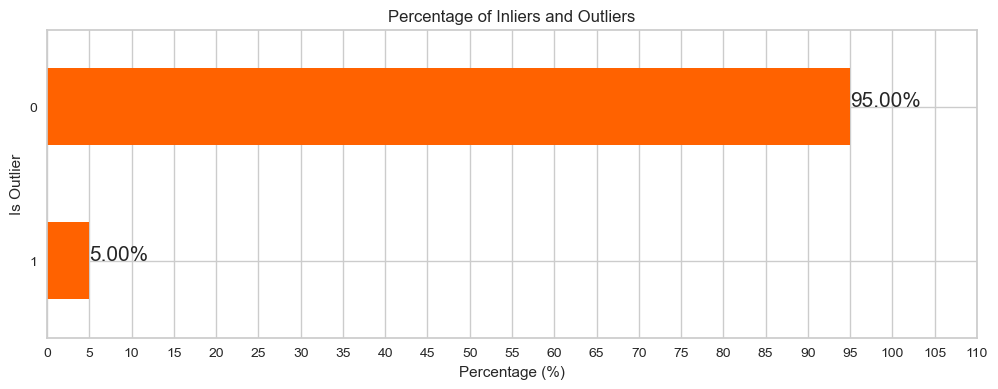

In [45]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [46]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [47]:
# Getting the number of rows in the cleaned customer dataset
customer_data_cleaned.shape[0]

20578

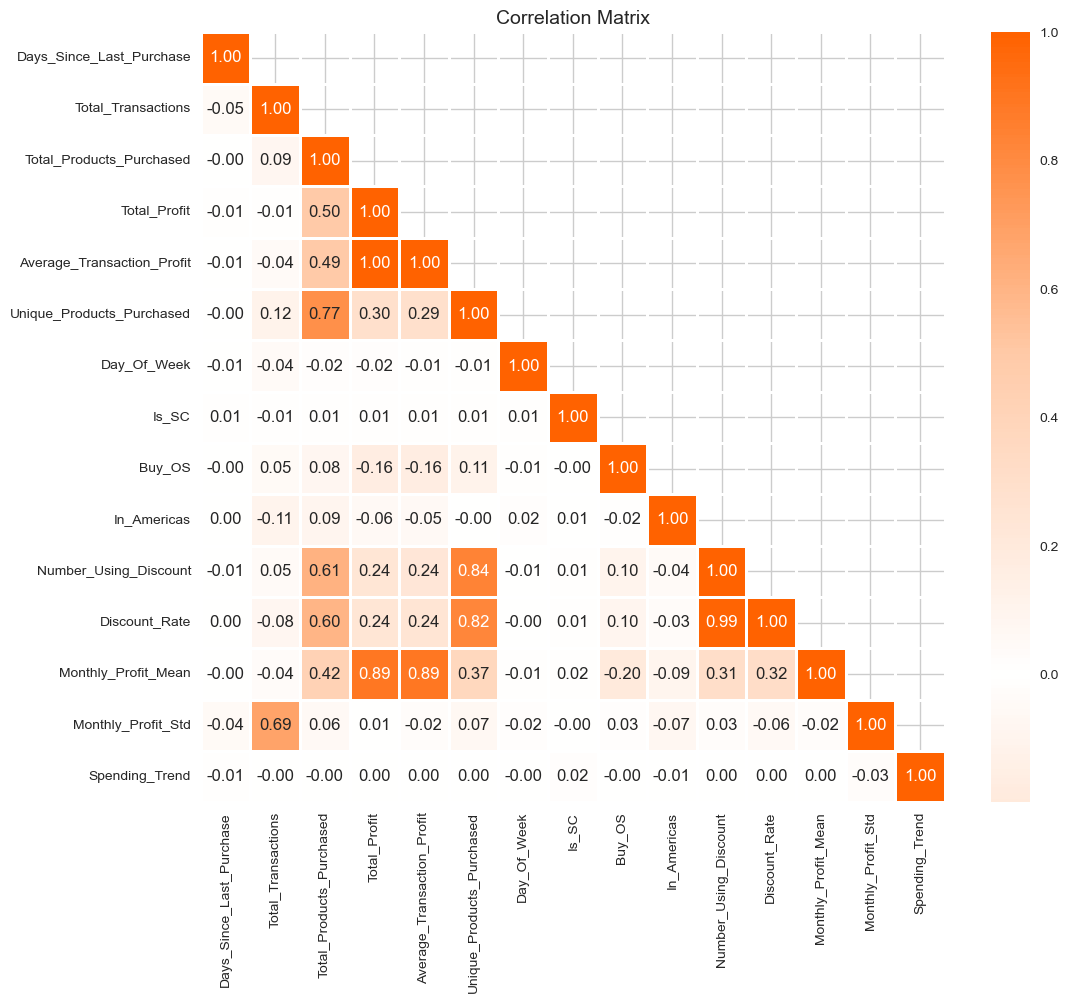

In [48]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['order_id']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

- Monthly_Profit_Mean, Total_Profit, and Average_Transaction_Profit, 
- Unique_Products_Purchased, Number_Using_Discount, and Discount_Rate,
- Total_Profit,Average_Transaction_Profit 
have high correlations. This indicates that the data to be clustered experiences multicollinearity. Therefore, before processing the data into segments, PCA is applied to reduce dimensionality and address multicollinearity. Multicollinearity affects the clustering results, and dimensionality reduction ensures that the process does not take too long to run.

In [49]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['order_id', 'Is_SC', 'Day_Of_Week','Buy_OS','In_Americas',]

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

order_id  Days_Since_Last_Purchase  Total_Transactions  \
0  AG-2011-1070                  1.390794           -0.124867   
1  AG-2011-1390                  1.501809           -0.124867   
2  AG-2011-1440                  1.209791           -0.124867   
3  AG-2011-2040                  2.049643           -0.124867   
4  AG-2011-3090                  1.509049           -0.124867   

   Total_Products_Purchased  Total_Profit  Average_Transaction_Profit  \
0                 -1.082789     -0.492240                   -0.488481   
1                  1.542809      3.162952                    3.169546   
2                 -0.880820     -0.521411                   -0.517674   
3                 -0.880820     -0.279749                   -0.275825   
4                 -0.880820     -0.548168                   -0.544452   

   Unique_Products_Purchased  Day_Of_Week  Is_SC  Buy_OS  In_Americas  \
0                  -0.740984            5      0       1            0   
1                   0.144702            1      1       1            0   
2                  -0.740984            3      1       1            0   
3                  -0.740984            5      1       1            0   
4                  -0.740984            5      1       0            0   

   Number_Using_Discount  Discount_Rate  Monthly_Profit_Mean  \
0              -0.650774      -0.636785            -0.232952   
1               0.364128       0.381695             0.972057   
2              -0.650774      -0.636785            -0.541681   
3              -0.650774      -0.636785             0.100061   
4              -0.650774      -0.636785            -0.612736   

   Monthly_Profit_Std  Spending_Trend  
0           -0.088452       -0.000544  
1           -0.088452       -0.000544  
2           -0.088452       -0.000544  
3           -0.088452       -0.000544  
4           -0.088452       -0.000544

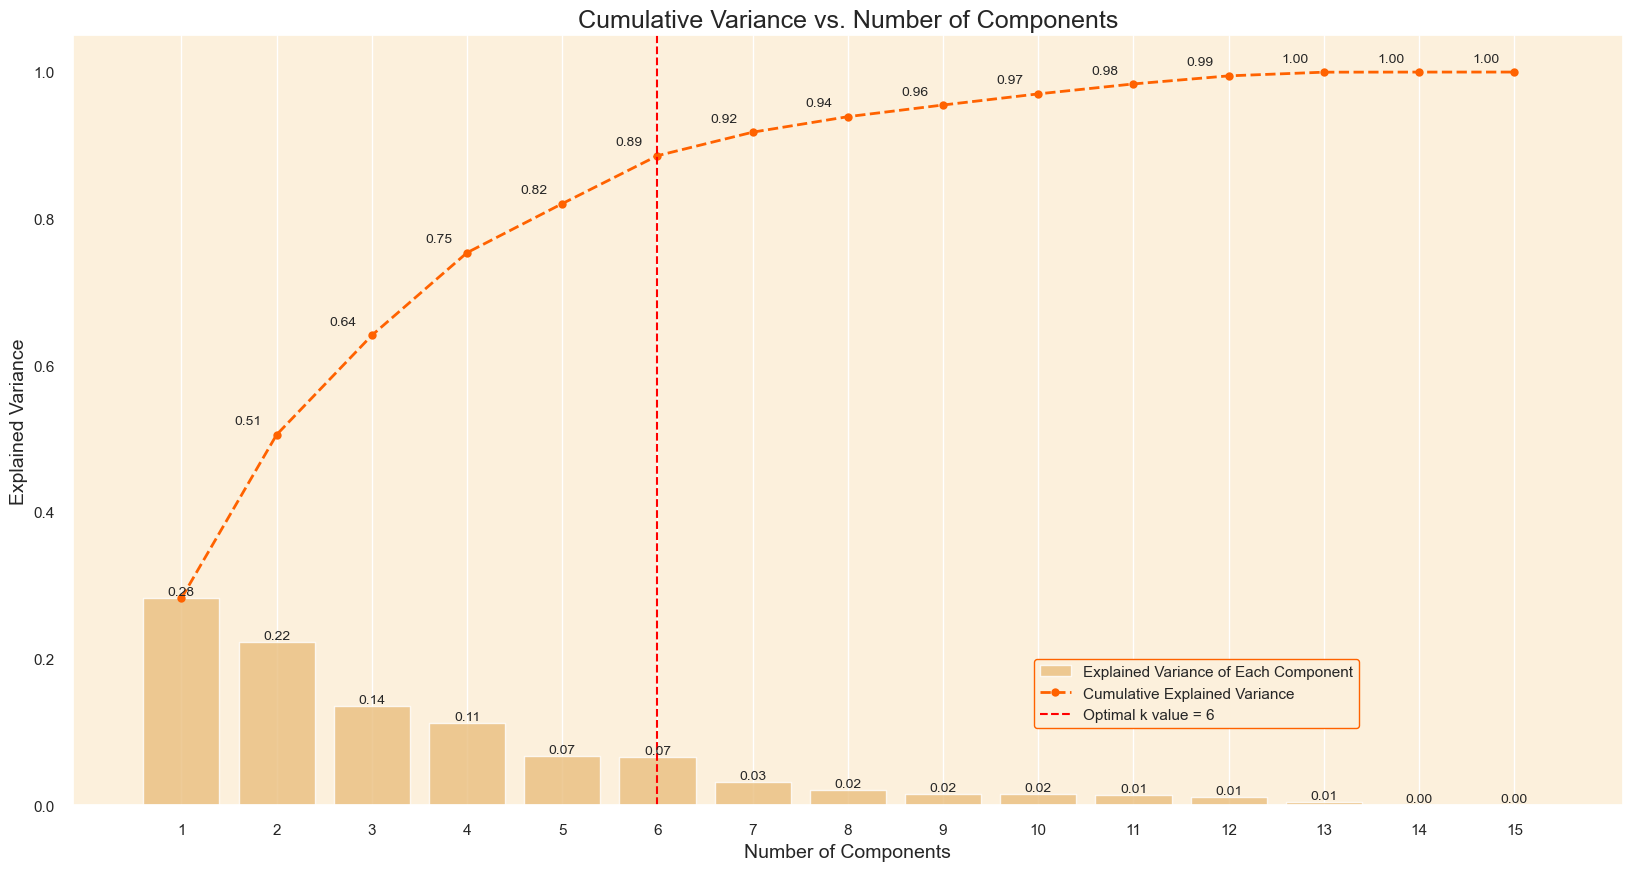

In [50]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('order_id', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()


In [51]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6
order_id                                                                
AG-2011-1070 -1.799280  2.302179  0.353125 -0.077580  0.818895  1.106713
AG-2011-1390  3.700392 -1.395287  2.680013  0.244135  0.915878  1.207269
AG-2011-1440 -1.730483  0.307869  0.186201 -0.177288  0.707531  0.960038
AG-2011-2040 -1.440867  2.321409  0.652446 -0.075898  1.209834  1.651264
AG-2011-3090 -1.892851  2.301479  0.228523 -0.113340  0.887179  1.216714

In [52]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

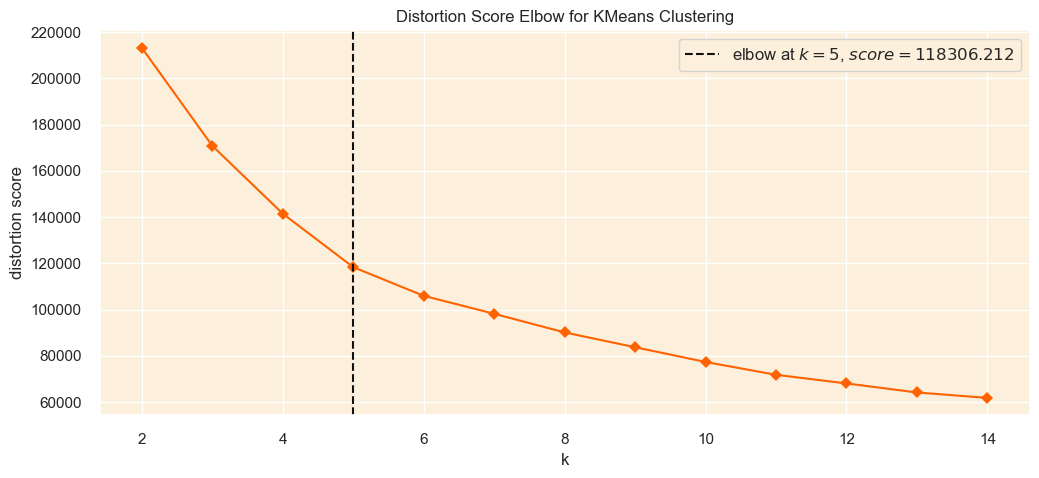

In [53]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

In [54]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

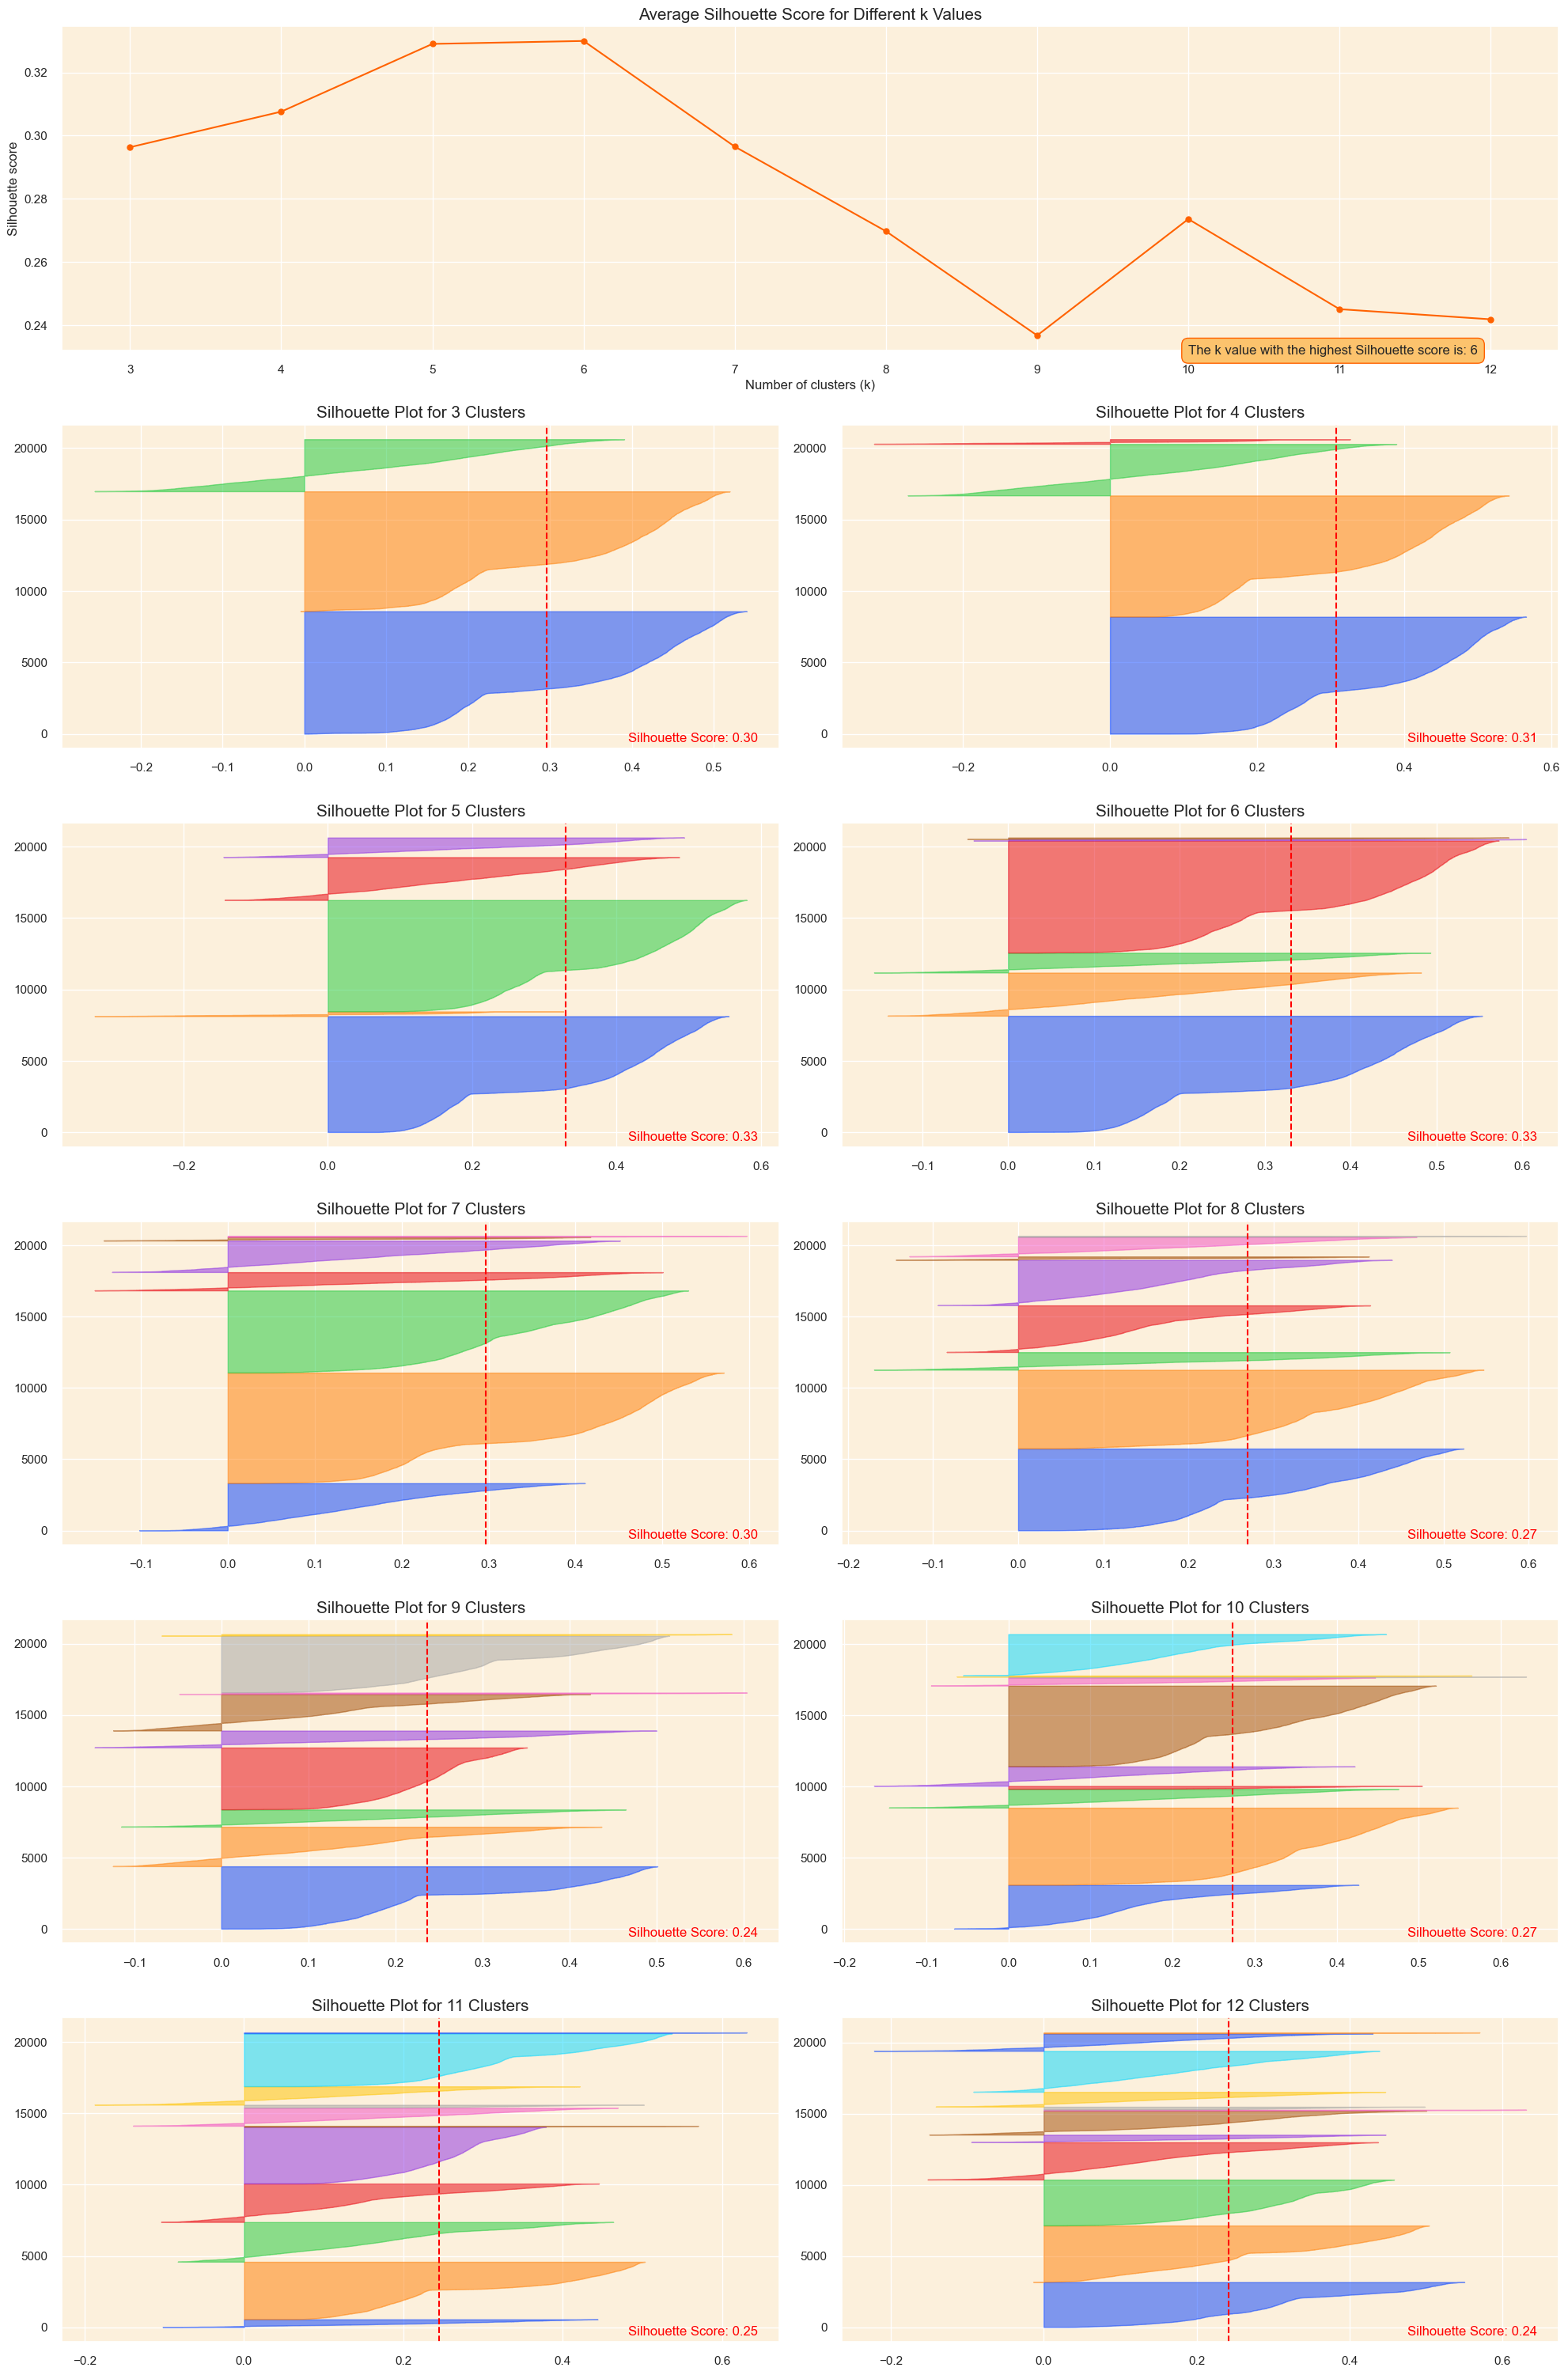

In [55]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

In [56]:

# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {4: 0, 3: 1, 2: 2, 1: 3, 0: 4}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [57]:
colors = ['#e8000b', '#1ac938', '#023eff', '#8e24aa', '#ffa07a']
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]
cluster_3 = customer_data_pca[customer_data_pca['cluster'] == 3]
cluster_4 = customer_data_pca[customer_data_pca['cluster'] == 4]

# Create a 3D scatter plot
import plotly.graph_objects as go

fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))
fig.add_trace(go.Scatter3d(x=cluster_3['PC1'], y=cluster_3['PC2'], z=cluster_3['PC3'], 
                           mode='markers', marker=dict(color=colors[3], size=5, opacity=0.4), name='Cluster 3'))
fig.add_trace(go.Scatter3d(x=cluster_4['PC1'], y=cluster_4['PC2'], z=cluster_4['PC3'], 
                           mode='markers', marker=dict(color=colors[4], size=5, opacity=0.4), name='Cluster 4'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

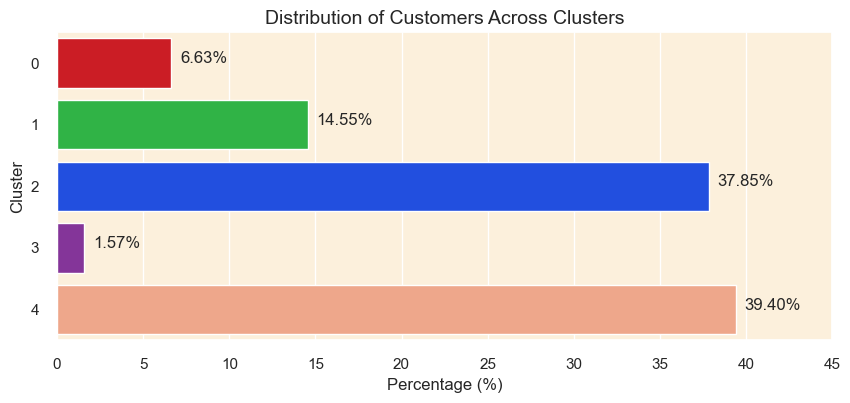

In [58]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

The best distribution of clusters is in clusters 1, 2, and 4. Therefore, the ideal target for marketing would be those who exhibit the characteristics of these clusters.

In [59]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        20578        |
|    Silhouette Score     | 0.32904045881852856 |
| Calinski Harabasz Score |  6804.309552316273  |
|  Davies Bouldin Score   | 1.0776505147396525  |
+-------------------------+---------------------+


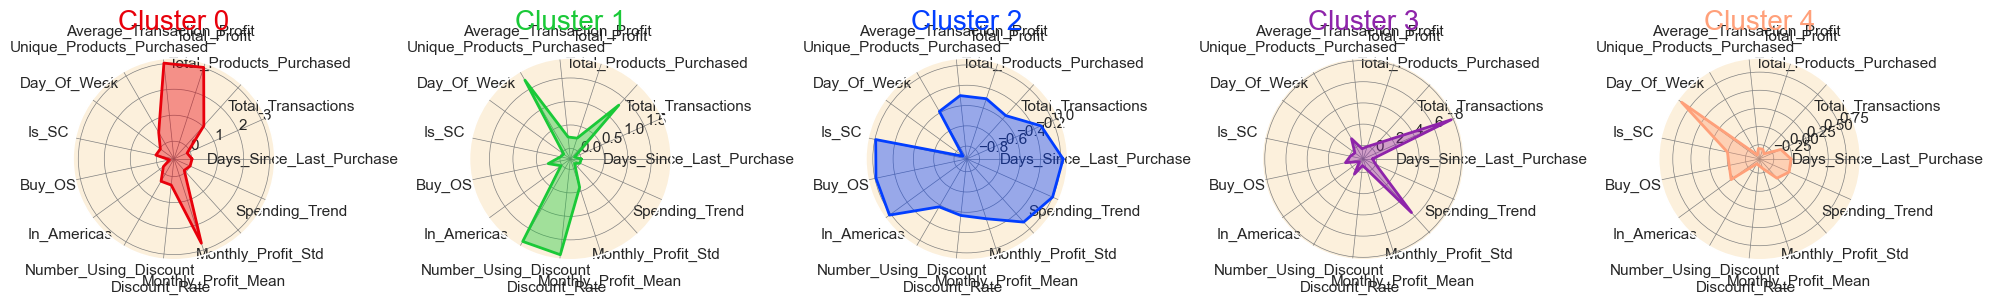

In [60]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('order_id')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]
# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=5)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
for i in range(5):
    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(labels[:-1])

# Add a grid
for i in range(5):
    ax[i].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

##### Cluster 0: Monthly Shopper 
Characteristics:
- Moderate amount of shopping, neither too much nor too little
- Generates significant profit
- Regularly shops almost every month
- Only Buy Teknologi or Furnitur
##### Cluster 1: Discount Shopper 
Characteristics:
- Always purchases different items
- Buys a considerable number of products
- Consistently uses discounts in every purchase
- Purchase at the beginning of the week.
##### Cluster 2: Office Supplies Subscriber 
Characteristics:
- Consistently buys office supplies
- Shipping is done using standard class mode
- Purchases are sent to the US or LATAM
- Frequently makes purchases
##### Cluster 3: Same Purchase Pattern 
Characteristics:
- Likes to transact
- Makes purchases almost every month
- Not located in the American continent
##### Cluster 4: Holiday Shopper 
Characteristics:
- Purchases are made on weekends
- Never uses discounts

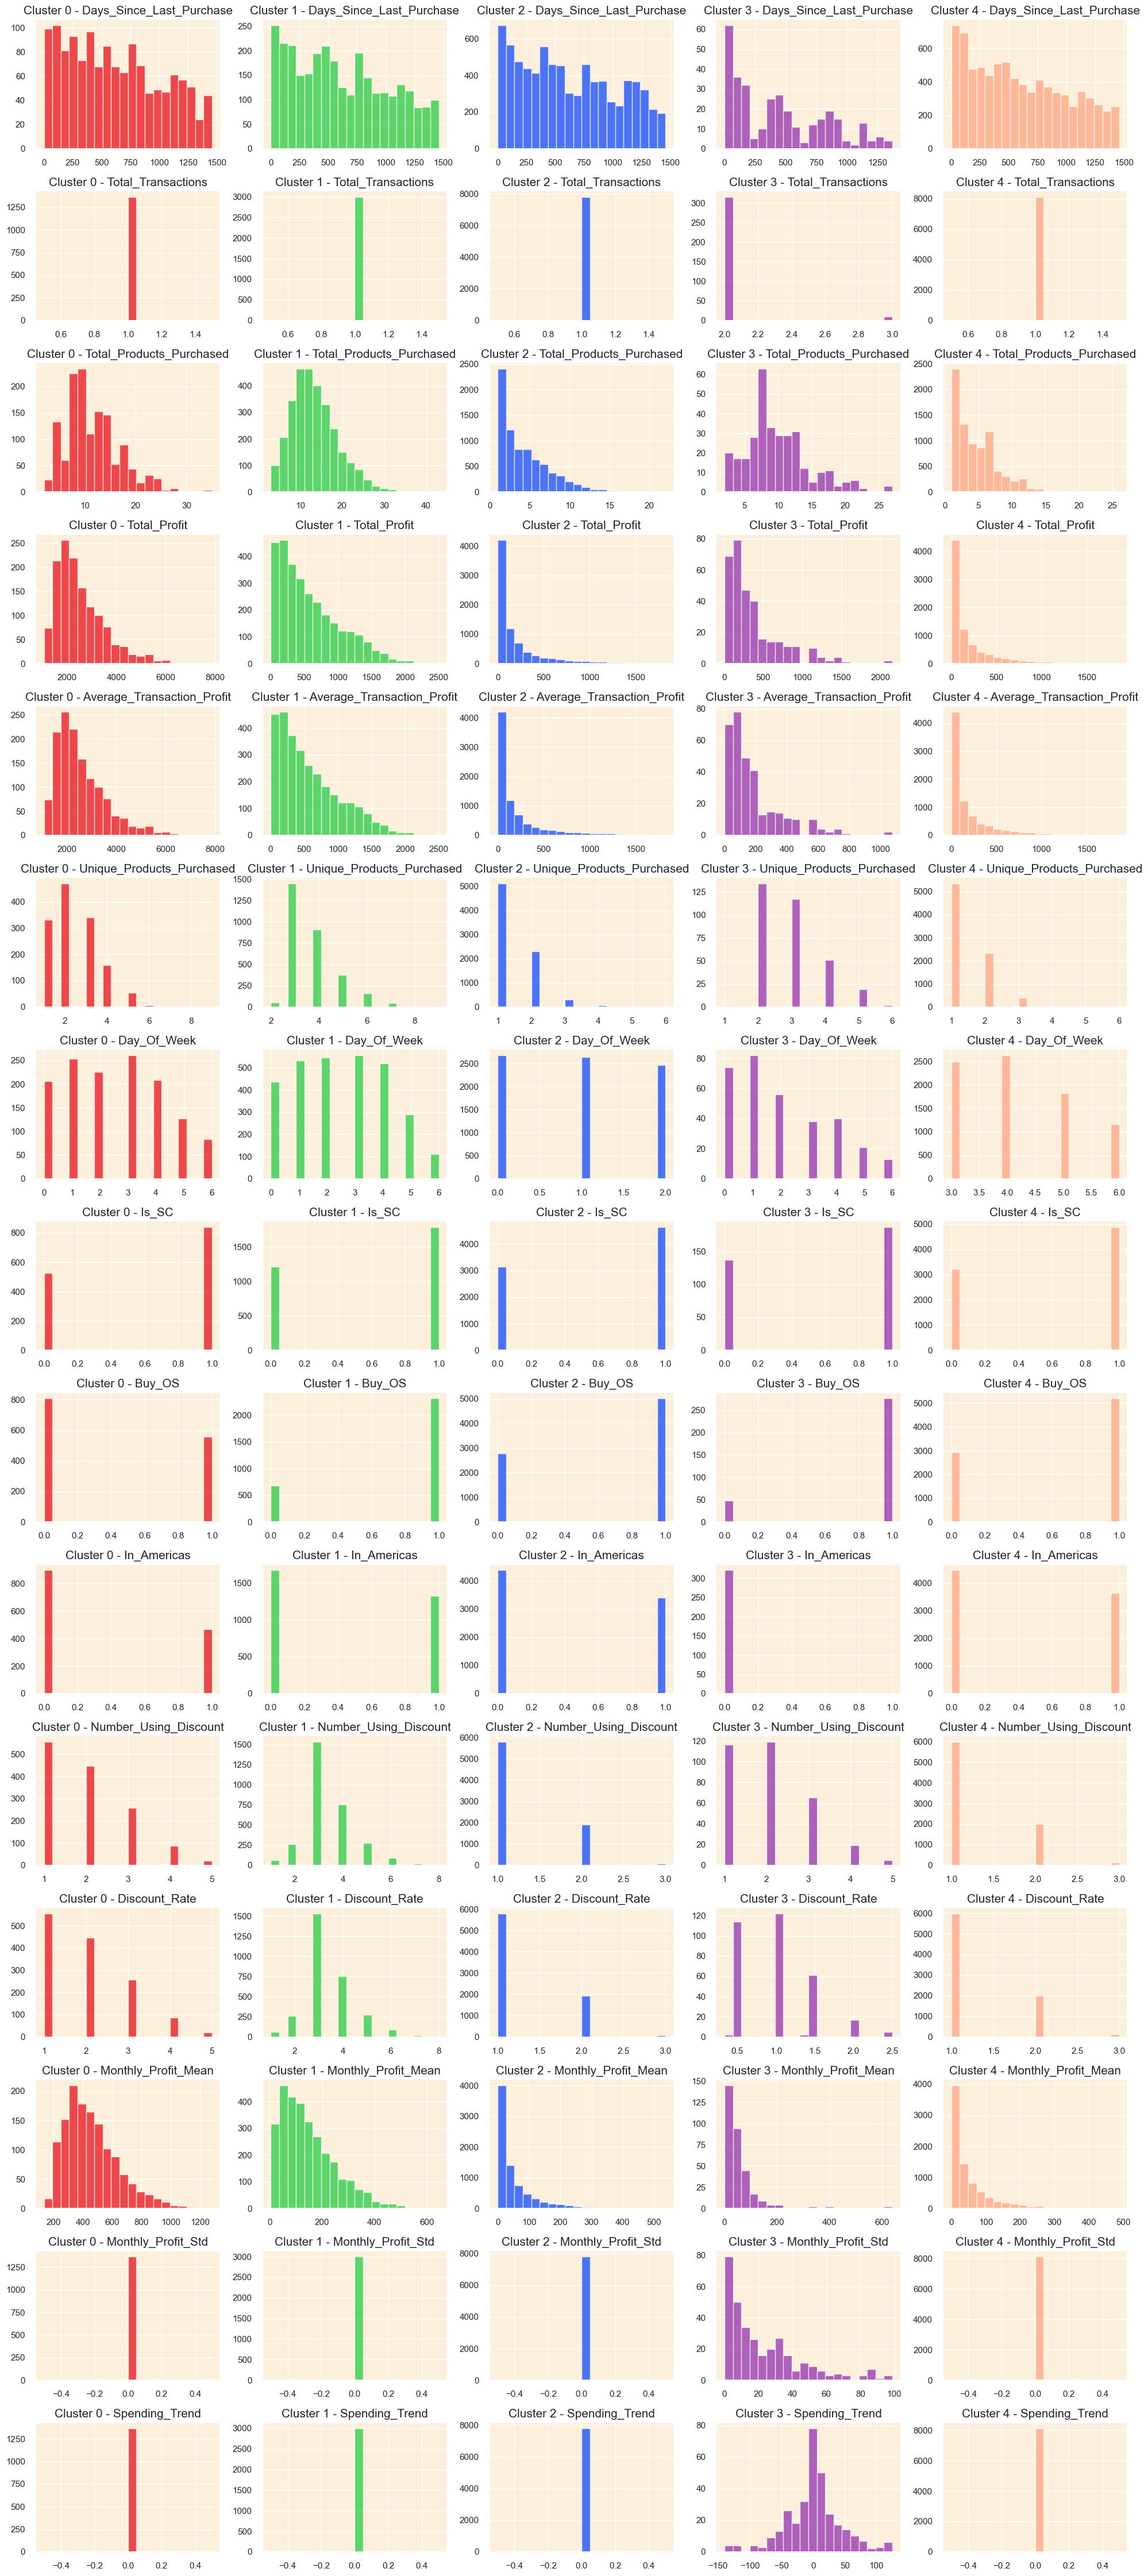

In [61]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

In [62]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['order_id'].astype('string').unique()
df_filtered = df[~df['order_id'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['order_id'] = customer_data_cleaned['order_id'].astype('string')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['order_id', 'cluster']], on='order_id', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'product_id', 'product_name'])['quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['order_id', 'cluster', 'product_id'])['quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['order_id']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['order_id'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['product_id'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['product_id'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['product_id', 'product_name']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['order_id', 'cluster', 'Rec1_product_id', 'Rec1_product_name', \
                                                 'Rec2_product_id', 'Rec2_product_name', 'Rec3_product_id', 'Rec3_product_name'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['order_id', 'cluster'], how='right')

In [63]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('order_id').iloc[:, -6:].sample(10, random_state=0)

Rec1_product_id  \
order_id                           
UZ-2014-6400     OFF-BI-10001253   
IN-2013-18805    OFF-BI-10001524   
ES-2011-3911616  OFF-BI-10001294   
PL-2013-8560     OFF-AR-10001228   
ES-2014-5263546  OFF-AR-10001228   
CA-2012-151841   OFF-BI-10001524   
ES-2012-2393484  OFF-BI-10001524   
ID-2014-77864    OFF-BI-10001524   
CG-2011-3350     OFF-BI-10001294   
CA-2013-133340   OFF-BI-10001524   

                                                 Rec1_product_name  \
order_id                                                             
UZ-2014-6400                          Acco Binder Covers, Recycled   
IN-2013-18805    GBC Premium Transparent Covers with Diagonal L...   
ES-2011-3911616                             Fellowes Binding Cases   
PL-2013-8560                          Stanley Markers, Water Color   
ES-2014-5263546                       Stanley Markers, Water Color   
CA-2012-151841   GBC Premium Transparent Covers with Diagonal L...   
ES-2012-2393484  GBC Premium Transparent Covers with Diagonal L...   
ID-2014-77864    GBC Premium Transparent Covers with Diagonal L...   
CG-2011-3350                                Fellowes Binding Cases   
CA-2013-133340   GBC Premium Transparent Covers with Diagonal L...   

                 Rec2_product_id                         Rec2_product_name  \
order_id                                                                     
UZ-2014-6400     OFF-AR-10000594  Binney & Smith Highlighters, Water Color   
IN-2013-18805    FUR-TA-10001095        Chromcraft Round Conference Tables   
ES-2011-3911616  OFF-AR-10002783     Stanley Pencil Sharpener, Water Color   
PL-2013-8560     FUR-CH-10003733       Hon Steel Folding Chair, Set of Two   
ES-2014-5263546  FUR-CH-10003733       Hon Steel Folding Chair, Set of Two   
CA-2012-151841   FUR-TA-10001095        Chromcraft Round Conference Tables   
ES-2012-2393484  FUR-TA-10001095        Chromcraft Round Conference Tables   
ID-2014-77864    FUR-TA-10001095        Chromcraft Round Conference Tables   
CG-2011-3350     OFF-AR-10002783     Stanley Pencil Sharpener, Water Color   
CA-2013-133340   FUR-TA-10001095        Chromcraft Round Conference Tables   

                 Rec3_product_id                        Rec3_product_name  
order_id                                                                   
UZ-2014-6400     OFF-FA-10002803                     Accos Staples, Metal  
IN-2013-18805    OFF-EN-10003850  GlobeWeis Clasp Envelope, Security-Tint  
ES-2011-3911616  TEC-PH-10004071                  PayAnywhere Card Reader  
PL-2013-8560     OFF-BI-10003883                     Acco Binder, Economy  
ES-2014-5263546  OFF-BI-10003883                     Acco Binder, Economy  
CA-2012-151841   OFF-EN-10003850  GlobeWeis Clasp Envelope, Security-Tint  
ES-2012-2393484  OFF-EN-10003850  GlobeWeis Clasp Envelope, Security-Tint  
ID-2014-77864    OFF-EN-10003850  GlobeWeis Clasp Envelope, Security-Tint  
CG-2011-3350     TEC-PH-10004071                  PayAnywhere Card Reader  
CA-2013-133340   OFF-EN-10003850  GlobeWeis Clasp Envelope, Security-Tint

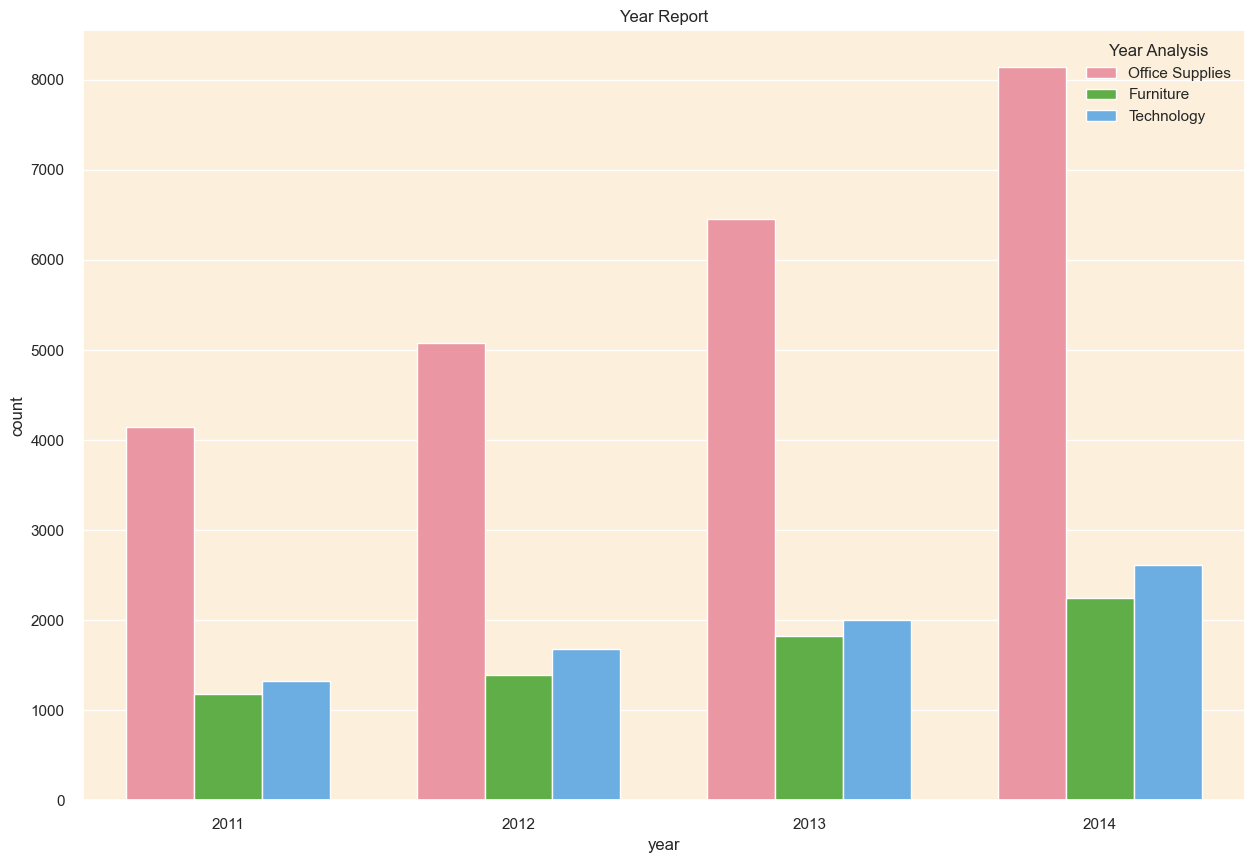

In [68]:
plt.figure(figsize=(15,10))
temp_df = df[['year','category']].sort_values(by='year')
plot = sns.countplot(data=temp_df, x='year', hue='category', width=0.7,)
plot.legend(title='Year Analysis')
plt.title('Year Report')
plt.show()